In [323]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('darkgrid')
from collections import Counter
from numpy import argmax
import time
from IPython.display import display
import pprint

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Feature Selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Modeling
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

# Save Model
import pickle

In [ ]:
!pwd

Datasets:
* Dataset pre-processed: ./Data/df_preprocess_done.csv
* Dataset for prediction: ./Data/df_prediction.csv'

In [174]:
df = pd.read_csv('./Data/df_preprocess_done.csv', index_col=0)
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head()

Size of the dataset:  20095
Number of variables: 29


churn       age  purchases_partners  cc_application_begin  \
user                                                               
50488      0 -1.343601            0.337098              0.363497   
53603      0  0.824089            0.299623             -0.096405   
42289      1  1.064943           -0.449882             -0.249706   
4185       0  0.342380           -0.749683             -0.249706   
12436      1 -0.861892            0.674375              0.210196   

       app_downloaded  web_user  android_user  left_for_two_month_plus  \
user                                                                     
50488               1         0             1                        0   
53603               1         0             1                        0   
42289               1         1             1                        0   
4185                1         1             0                        0   
12436               1         1             1                        0   

       left_for_one_month  reward_rate  ...  zodiac_sign_Cancer  \
user                                    ...                       
50488                   0    -0.617441  ...                   0   
53603                   0    -0.307211  ...                   0   
42289                   0    -0.361164  ...                   0   
4185                    0     1.581146  ...                   0   
12436                   0    -0.226281  ...                   0   

       zodiac_sign_Capricorn  zodiac_sign_Gemini  zodiac_sign_Leo  \
user                                                                
50488                      0                   0                0   
53603                      0                   0                0   
42289                      0                   0                0   
4185                       0                   0                0   
12436                      0                   0                0   

       zodiac_sign_Libra  zodiac_sign_Pisces  zodiac_sign_Sagittarius  \
user                                                                    
50488                  0                   0                        0   
53603                  0                   0                        1   
42289                  0                   0                        0   
4185                   0                   0                        0   
12436                  0                   0                        0   

       zodiac_sign_Scorpio  zodiac_sign_Taurus  zodiac_sign_Virgo  
user                                                               
50488                    0                   0                  1  
53603                    0                   0                  0  
42289                    0                   0                  0  
4185                     1                   0                  0  
12436                    1                   0                  0  

[5 rows x 29 columns]

# 4. Modeling & Evaluation

For modeling, we faced the following faces:

1. Separate dataset 
    - For X and y classes. 
    - Split dataset for training and testing.
2. Feature Selection
    - Use linear regression model
    - Use other techniques like: 
        - Recursive Feature Elimination (RFE) as a wrapped method
        - Random Forest as embeded method
        - Mutual Information classification as entropy method
    - Then sum up and choose the most important features 
3. Modeling for finding the best:
    - Hyperparameter Tunning using GridSearchCV for finding the best hyperparameters of each model
    - Fitting and Evaluation using the next models:
        - Logistic Regresion Model¶
        - Decision Tree Model
        - Support Vector Machine Model
        - Random Forest Model
        - K-Nearest Neighbor Model
    - Choose the best model according metrics
    - Save the model to used with new values
    
For evaluation, we are using the following metrics:

- Confusion matrix
- Accuracy as classification metric
- Precision, Recall, F1-score
- Some graphs like ROC, Precision vs Recall, KS Statistic Test, Cummulative Gain, Lift Curve.

## 1. Separate dataset for X and y classes.

Here first, we split the data for features and label(churn variable). Then split for training and testing.

In [175]:
X = df.drop('churn', axis = 1)
y = df['churn'] 
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))


X shape: (20095, 28)
y shape: (20095,)


In [176]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (14066, 28)
y_train shape: (14066,)
x_test shape: (6029, 28)
y_test shape: (6029,)


In [177]:
x_train.columns, y_train.name

(Index(['age', 'purchases_partners', 'cc_application_begin', 'app_downloaded',
        'web_user', 'android_user', 'left_for_two_month_plus',
        'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
        'housing_R', 'payment_type_Bi-Weekly', 'payment_type_Monthly',
        'payment_type_Semi-Monthly', 'payment_type_Weekly',
        'zodiac_sign_Aquarius', 'zodiac_sign_Aries', 'zodiac_sign_Cancer',
        'zodiac_sign_Capricorn', 'zodiac_sign_Gemini', 'zodiac_sign_Leo',
        'zodiac_sign_Libra', 'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius',
        'zodiac_sign_Scorpio', 'zodiac_sign_Taurus', 'zodiac_sign_Virgo'],
       dtype='object'),
 'churn')

## 2. Feature Selection

For Feature Selection, we will use the following techniques:

- Use linear regression model
- Use other techniques like: 
  - Recursive Feature Elimination (RFE) as a wrapped method
  - Random Forest as embeded method
  - Mutual Information classification as entropy method
- Then sum up and choose the most important features 

### 2.1. Using Linear Regression Model

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

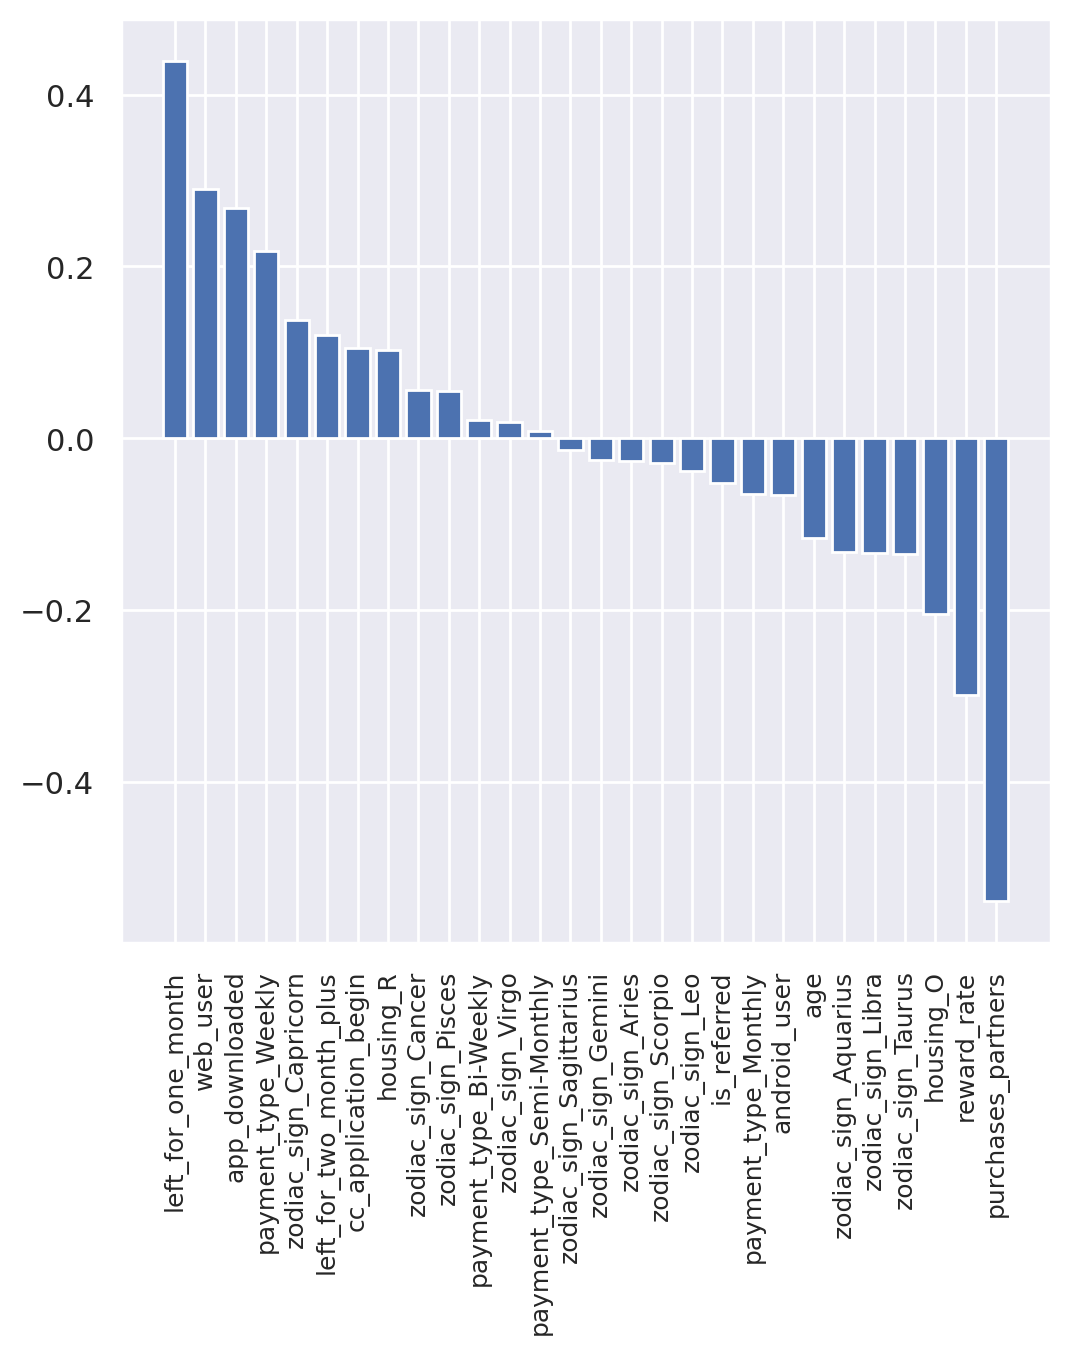

In [178]:
log_rg = LogisticRegression().fit(x_train, y_train)

feature_importance_lr = pd.DataFrame(zip(x_train.columns.values, log_rg.coef_.ravel()))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
plt.bar(feature_importance_lr['feature'], feature_importance_lr['coef'])
plt.xticks(rotation=90, fontsize=9)

In [179]:
feature_importance_lr.where((feature_importance_lr["coef"] < -0.2)|(feature_importance_lr["coef"] > 0.2)).dropna()

feature      coef
7    left_for_one_month  0.438657
4              web_user  0.289608
3        app_downloaded  0.268084
15  payment_type_Weekly  0.218277
10            housing_O -0.204331
8           reward_rate -0.298566
1    purchases_partners -0.538643

In [180]:
feature_logistic = list(feature_importance_lr.where((feature_importance_lr["coef"] < -0.2)|(feature_importance_lr["coef"] > 0.2)).dropna()['feature'].values)
print("More important features with coef < -0.1 and coef > 0.1: \n", "There is a {} features from {}".format(len(feature_logistic), x_train.shape[1]) )
feature_logistic

More important features with coef < -0.1 and coef > 0.1: 
 There is a 7 features from 28


['left_for_one_month',
 'web_user',
 'app_downloaded',
 'payment_type_Weekly',
 'housing_O',
 'reward_rate',
 'purchases_partners']

Using this model, the more important features with coef < -0.2 and coef > 0.2. There is 7 features from 28. We can see that the more important variables are:

- left_for_one_month
- web_user
- app_downloaded
- payment_type_Weekly
- housing_O
- reward_rate
- purchases_partners

In [181]:
lr_support_num = feature_importance_lr["coef"].values
lr_support = np.where((lr_support_num > 0.2)|(lr_support_num < -0.2), True, False)
lr_support

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True])

As a number of features, we will calculate the best 12 features using other methods. Later, we will sum up and then calculate the most importants.

In [182]:
num_feats = 12

### 2.2. Using Recursive Feature Elimination (RFE) as wrapped method

In [188]:
# Number of features as 12
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=12, step=10, verbose=5)
rfe_selector.fit(x_train, y_train)
rfe_support = rfe_selector.get_support()
feature_rfe = x_train.loc[:,rfe_support].columns.tolist()
print(str(len(feature_rfe)), 'selected features')
print(feature_rfe)

Fitting estimator with 28 features.
Fitting estimator with 18 features.
12 selected features
['purchases_partners', 'app_downloaded', 'web_user', 'left_for_two_month_plus', 'left_for_one_month', 'reward_rate', 'housing_O', 'payment_type_Weekly', 'zodiac_sign_Aquarius', 'zodiac_sign_Capricorn', 'zodiac_sign_Libra', 'zodiac_sign_Taurus']


In [189]:
feature_rfe

['purchases_partners',
 'app_downloaded',
 'web_user',
 'left_for_two_month_plus',
 'left_for_one_month',
 'reward_rate',
 'housing_O',
 'payment_type_Weekly',
 'zodiac_sign_Aquarius',
 'zodiac_sign_Capricorn',
 'zodiac_sign_Libra',
 'zodiac_sign_Taurus']

As a wrapped method, it use an external method or estimator(LogisticRegression in our case) for searching/select in a recursive way a small subset of features evaluating the importance. Using RFE model, the more 12 important features are:

- purchases_partners
- app_downloaded
- web_user
- left_for_two_month_plus
- left_for_one_month
- reward_rate
- housing_O
- payment_type_Weekly
- zodiac_sign_Aquarius
- zodiac_sign_Capricorn
- zodiac_sign_Libra
- zodiac_sign_Taurus


In [190]:
rfe_support

array([False,  True, False,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False,  True, False, False,  True, False, False, False,  True,
       False])

### 2.3. Using Random Forest as embeded method

In [198]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=12)
embeded_rf_selector.fit(x_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
feature_embeded_rf = x_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(feature_embeded_rf)), 'selected features')
feature_embeded_rf

4 selected features


['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']

In Random Forest, there is the purity of the node which tell us about the importance of the model. So if a node with low imputiry(Gini impurity) over all trees, this node will be the most important. Using the Random Forest model, there are only 4 important features:

- age
- purchases_partners
- cc_application_begin
- reward_rate

In [199]:
embeded_rf_support

array([ True,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

### 2.4. Using mutual info classif as entropy method

<AxesSubplot:>

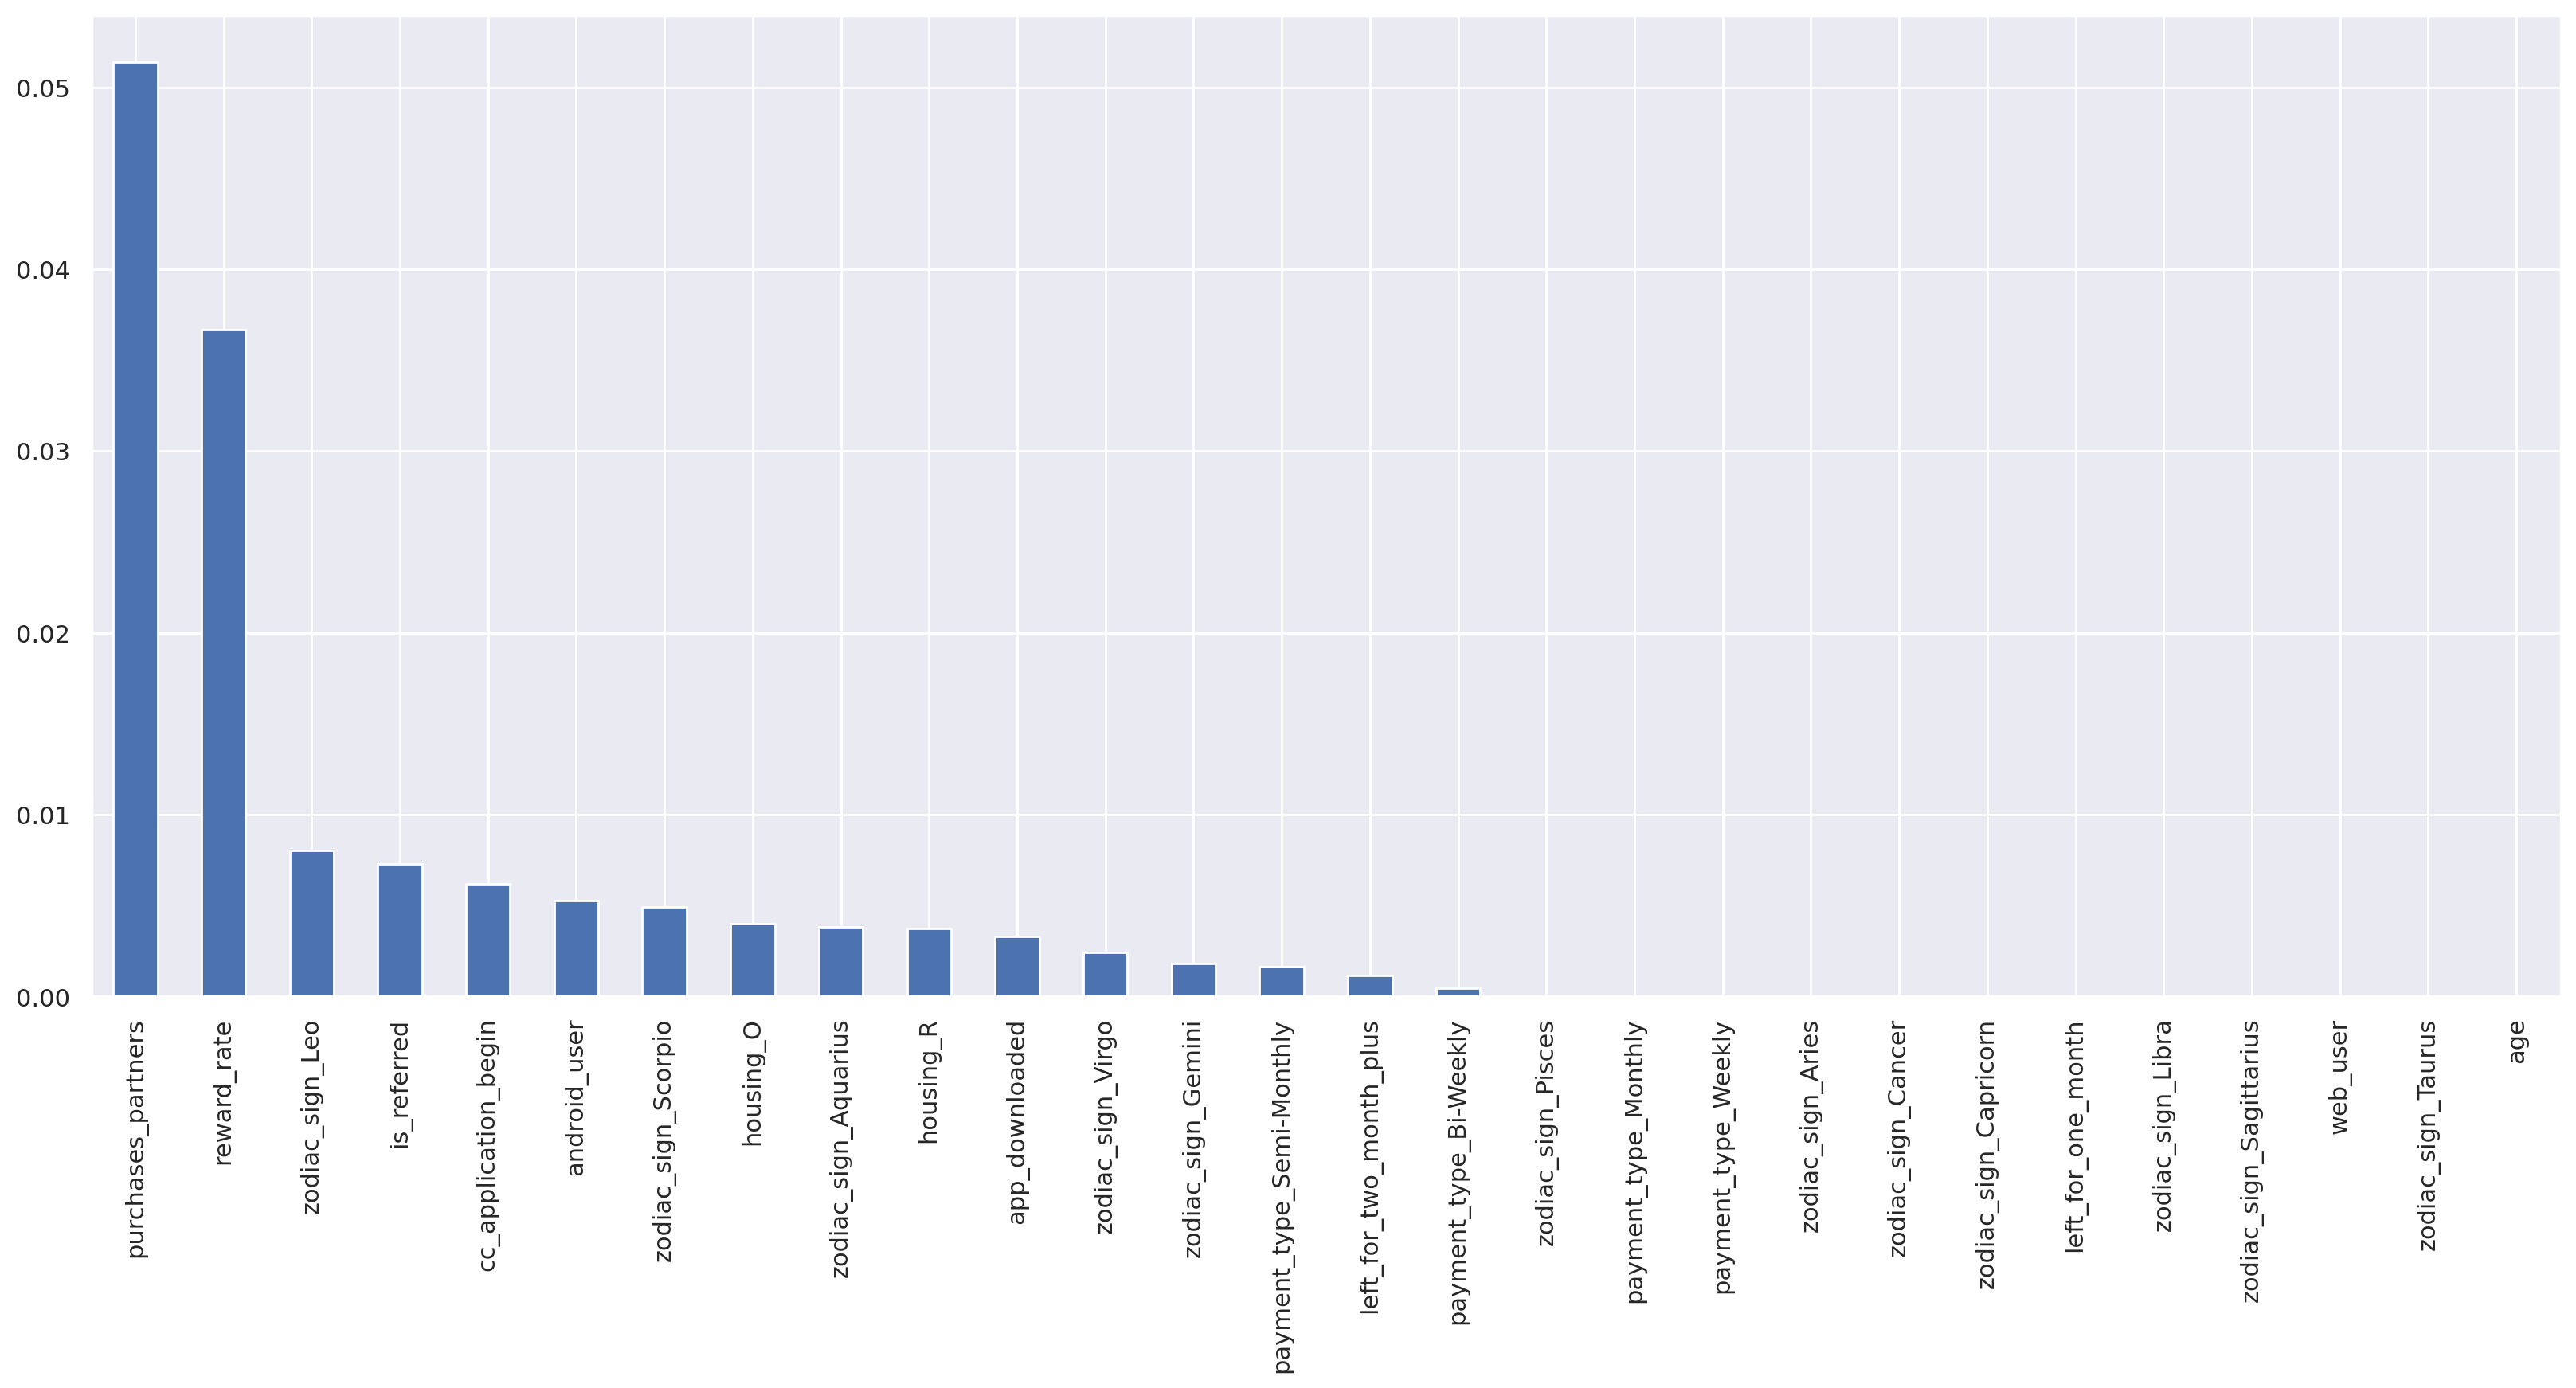

In [200]:
importances =  mutual_info_classif(x_train,y_train)
feature_mutual_importance = pd.Series(importances, index = x_train.columns)
feature_mutual_importance.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [201]:
feature_mutual_importance

age                          0.000000
purchases_partners           0.051373
cc_application_begin         0.006210
app_downloaded               0.003322
web_user                     0.000000
android_user                 0.005267
left_for_two_month_plus      0.001157
left_for_one_month           0.000000
reward_rate                  0.036654
is_referred                  0.007289
housing_O                    0.004022
housing_R                    0.003764
payment_type_Bi-Weekly       0.000480
payment_type_Monthly         0.000000
payment_type_Semi-Monthly    0.001628
payment_type_Weekly          0.000000
zodiac_sign_Aquarius         0.003820
zodiac_sign_Aries            0.000000
zodiac_sign_Cancer           0.000000
zodiac_sign_Capricorn        0.000000
zodiac_sign_Gemini           0.001806
zodiac_sign_Leo              0.008047
zodiac_sign_Libra            0.000000
zodiac_sign_Pisces           0.000029
zodiac_sign_Sagittarius      0.000000
zodiac_sign_Scorpio          0.004945
zodiac_sign_

In [203]:
feature_mutual_importance.where(feature_mutual_importance > 0.002).sort_values(ascending=False).dropna()

purchases_partners      0.051373
reward_rate             0.036654
zodiac_sign_Leo         0.008047
is_referred             0.007289
cc_application_begin    0.006210
android_user            0.005267
zodiac_sign_Scorpio     0.004945
housing_O               0.004022
zodiac_sign_Aquarius    0.003820
housing_R               0.003764
app_downloaded          0.003322
zodiac_sign_Virgo       0.002423
dtype: float64

In [205]:
feature_mutual = list(feature_mutual_importance.where(feature_mutual_importance > 0.002).sort_values(ascending=False).dropna().index)
print("There are {} important features and they are: \n".format(len(feature_mutual)))
feature_mutual

There are 12 important features and they are: 



['purchases_partners',
 'reward_rate',
 'zodiac_sign_Leo',
 'is_referred',
 'cc_application_begin',
 'android_user',
 'zodiac_sign_Scorpio',
 'housing_O',
 'zodiac_sign_Aquarius',
 'housing_R',
 'app_downloaded',
 'zodiac_sign_Virgo']

Mutual Information comes from information theory which apply information gain(like decision tree) to feature selection. This gain is calculated between 2 variables and it measures the reduction in uncertainty. Using this model, we can get the first 12 important features:

- purchases_partners
- reward_rate
- zodiac_sign_Leo
- is_referred
- cc_application_begin
- android_user
- zodiac_sign_Scorpio
- housing_O
- zodiac_sign_Aquarius
- housing_R
- app_downloaded
- zodiac_sign_Virgo

In [206]:
mutual_support = np.where(importances > 0.002, True, False)
mutual_support

array([False,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False,  True, False,
        True])

### 2.5. Sum up and putting all together

In [207]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':x_train.columns, 
                                     'Logistics':lr_support,
                                     'RFE':rfe_support,
                                     'Random Forest':embeded_rf_support, 'Mutual Classif':mutual_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
# feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

Feature  Logistics    RFE  Random Forest  Mutual Classif  \
1     purchases_partners       True   True           True            True   
8            reward_rate      False   True           True            True   
2   cc_application_begin       True  False           True            True   
3         app_downloaded       True   True          False            True   
27     zodiac_sign_Virgo       True  False          False            True   
26    zodiac_sign_Taurus       True   True          False           False   
25   zodiac_sign_Scorpio       True  False          False            True   
16  zodiac_sign_Aquarius      False   True          False            True   
10             housing_O      False   True          False            True   
0                    age       True  False           True           False   
22     zodiac_sign_Libra      False   True          False           False   
21       zodiac_sign_Leo      False  False          False            True   

    Total  
1       4  
8       3  
2       3  
3       3  
27      2  
26      2  
25      2  
16      2  
10      2  
0       2  
22      1  
21      1

In [208]:
new_num_features = list(feature_selection_df['Feature'][0:12].values)
print("Here the most important features we will use for modeling:\n")
new_num_features

Here the most important features we will use for modeling:



['purchases_partners',
 'reward_rate',
 'cc_application_begin',
 'app_downloaded',
 'zodiac_sign_Virgo',
 'zodiac_sign_Taurus',
 'zodiac_sign_Scorpio',
 'zodiac_sign_Aquarius',
 'housing_O',
 'age',
 'zodiac_sign_Libra',
 'zodiac_sign_Leo']

Now we are ready to start modeling. For this we split again the dataset but filtering using the **new_num_features** list.

In [209]:
X = X[new_num_features]
y = df['churn']
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))


X shape: (20095, 12)
y shape: (20095,)


In [210]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (14066, 12)
y_train shape: (14066,)
x_test shape: (6029, 12)
y_test shape: (6029,)


In [211]:
x_train

purchases_partners  reward_rate  cc_application_begin  app_downloaded  \
user                                                                           
57638           -0.374931    -0.806277             -0.249706               1   
50167           -0.524832    -0.981624             -0.862909               1   
44004            0.374573     0.542550              0.056896               1   
1198             1.199028     0.003019             -0.709608               1   
3315             0.711850     1.527193              2.049805               1   
...                   ...          ...                   ...             ...   
35649           -0.749683    -0.172328              0.210196               1   
62321           -0.749683    -1.210924             -0.862909               0   
63299           -0.674733    -1.210924             -0.862909               1   
21502           -0.299981    -1.116507             -0.556307               1   
29028            0.412048    -0.172328              0.363497               1   

       zodiac_sign_Virgo  zodiac_sign_Taurus  zodiac_sign_Scorpio  \
user                                                                
57638                  0                   0                    0   
50167                  1                   0                    0   
44004                  0                   0                    0   
1198                   0                   1                    0   
3315                   0                   0                    1   
...                  ...                 ...                  ...   
35649                  0                   1                    0   
62321                  0                   0                    0   
63299                  0                   0                    0   
21502                  0                   0                    0   
29028                  1                   0                    0   

       zodiac_sign_Aquarius  housing_O       age  zodiac_sign_Libra  \
user                                                                  
57638                     0          0  1.064943                  0   
50167                     0          0 -0.500610                  0   
44004                     0          0 -0.500610                  0   
1198                      0          0 -1.464028                  0   
3315                      0          0  1.907934                  0   
...                     ...        ...       ...                ...   
35649                     0          0 -0.982319                  0   
62321                     0          0 -0.621038                  0   
63299                     0          0 -0.500610                  0   
21502                     0          0 -1.584455                  0   
29028                     0          1 -0.380183                  0   

       zodiac_sign_Leo  
user                    
57638                0  
50167                0  
44004                0  
1198                 0  
3315                 0  
...                ...  
35649                0  
62321                0  
63299                1  
21502                0  
29028                0  

[14066 rows x 12 columns]

## 3. Modeling for finding the best:

Modeling for finding the best:

- Hyperparameter Tunning using GridSearchCV for finding the best hyperparameters of each model
- Fitting and Evaluation using the next models:
    - Logistic Regresion Model¶
    - Decision Tree Model
    - Support Vector Machine Model
    - Random Forest Model
    - K-Nearest Neighbor Model
- Choose the best model according metrics
- Save the model to used with new values
    
For evaluation, we are using the following metrics:

- Confusion matrix
- Accuracy as classification metric
- Precision, Recall, F1-score
- Some graphs like ROC, Precision vs Recall, KS Statistic Test, Cummulative Gain, Lift Curve.

In [212]:
# GridSearch results function

def GridSearchResults(grid_clf, num_results=10, display_all_params=True):
    """
    Function to summary all the results of gridsearchCV.
    """

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("Best parameters: \n {}".format(clf_params))
    print("Best score: \n {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    print("All parameters: " )
    if display_all_params:
        pprint.pprint(clf.get_params())

    # Show best results
    scores_df = pd.DataFrame(cv_results, columns = ['params', 'mean_test_score',	'std_test_score', 'rank_test_score']).sort_values(by='rank_test_score')
    display(scores_df.head(num_results))

   

In [213]:
# Evaluation Function

def evaluationMetricsGCV(x_test, y_test, model_fit):
    """
    Function to summary all the results of fitting and predicting.
    """
    y_pred = model_fit.predict(x_test)
    y_prob = model_fit.predict_proba(x_test)
    Accuracy = accuracy_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)  
    F1 = f1_score(y_test, y_pred)
    
    print("\n")
    print("Results: ")
    
    for i in ['Accuracy', 'Precision', 'Recall', 'F1']:
        print('{} {} {:.3f}'.format(5*str('+') ,i+' Score' , locals()[i]))
    print("\n")
    
    target_names = ['No churn', 'Churn']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    auc_score = roc_auc_score(y_test, y_pred)
    print("{} AUC (Area under the ROC Curve) : {:.3f}\n".format(5*str('+'), auc_score))
    print("\n")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    plt.title("Confusion Matrix")
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Real Values')
    plt.xlabel('Prediction');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_roc_curve(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_ks_statistic(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_precision_recall(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_cumulative_gain(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_lift_curve(y_test, y_prob)
    
    return Accuracy, Precision, Recall, F1, auc_score, y_pred, y_prob

In [282]:
# Dataframe for statistics

model_stats = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-Score"])
model_stats.head()

Empty DataFrame
Columns: [Model, Accuracy, Precision, Recall, F1-Score, AUC-Score]
Index: []

### 3.1. Logistic Regresion Model

#### Hyperparameters Tunning

In [215]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['C'] = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
#parameters['C'] = np.logspace(-1,1,10) 
parameters['class_weight'] = [None, 'balanced']
parameters['penalty'] = ["l1","l2",'elasticnet']
parameters['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag']

GS_log = GridSearchCV(LogisticRegression(), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_log.fit(x_train, y_train)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 1, 10, 100, 1000],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             scoring='accuracy', verbose=1)

In [216]:
GridSearchResults(GS_log)

Best parameters: 
 {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 
 0.63038 (+/-0.01300)
All parameters: 
{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


params  mean_test_score  \
2   {'C': 0.01, 'class_weight': None, 'penalty': '...         0.630383   
6   {'C': 0.01, 'class_weight': None, 'penalty': '...         0.627824   
26  {'C': 0.1, 'class_weight': None, 'penalty': 'l...         0.627611   
4   {'C': 0.01, 'class_weight': None, 'penalty': '...         0.627469   
5   {'C': 0.01, 'class_weight': None, 'penalty': '...         0.627469   
7   {'C': 0.01, 'class_weight': None, 'penalty': '...         0.627469   
29  {'C': 0.1, 'class_weight': None, 'penalty': 'l...         0.627184   
31  {'C': 0.1, 'class_weight': None, 'penalty': 'l...         0.627184   
28  {'C': 0.1, 'class_weight': None, 'penalty': 'l...         0.627184   
30  {'C': 0.1, 'class_weight': None, 'penalty': 'l...         0.626971   

    std_test_score  rank_test_score  
2         0.012998                1  
6         0.013089                2  
26        0.012696                3  
4         0.012713                4  
5         0.012713                4  
7         0.012713                4  
29        0.013151                7  
31        0.013151                7  
28        0.013151                7  
30        0.013364               10

#### Modeling

In [217]:
logr_model = LogisticRegression(C=0.01, class_weight=None, max_iter=1000, penalty='l1', random_state=1000, solver='liblinear')
logr_model.fit(x_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, penalty='l1', random_state=1000,
                   solver='liblinear')

#### Evaluation



Results: 
+++++ Accuracy Score 0.639
+++++ Precision Score 0.598
+++++ Recall Score 0.570
+++++ F1 Score 0.584


              precision    recall  f1-score   support

    No churn       0.67      0.69      0.68      3354
       Churn       0.60      0.57      0.58      2675

    accuracy                           0.64      6029
   macro avg       0.63      0.63      0.63      6029
weighted avg       0.64      0.64      0.64      6029

+++++ AUC (Area under the ROC Curve) : 0.632





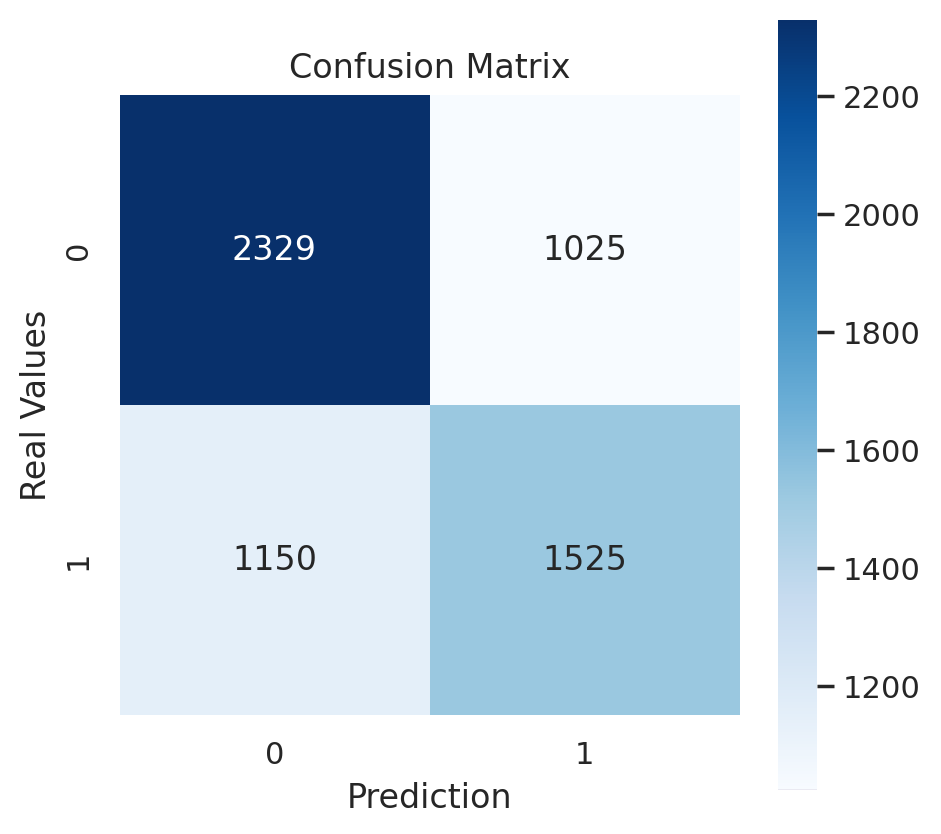

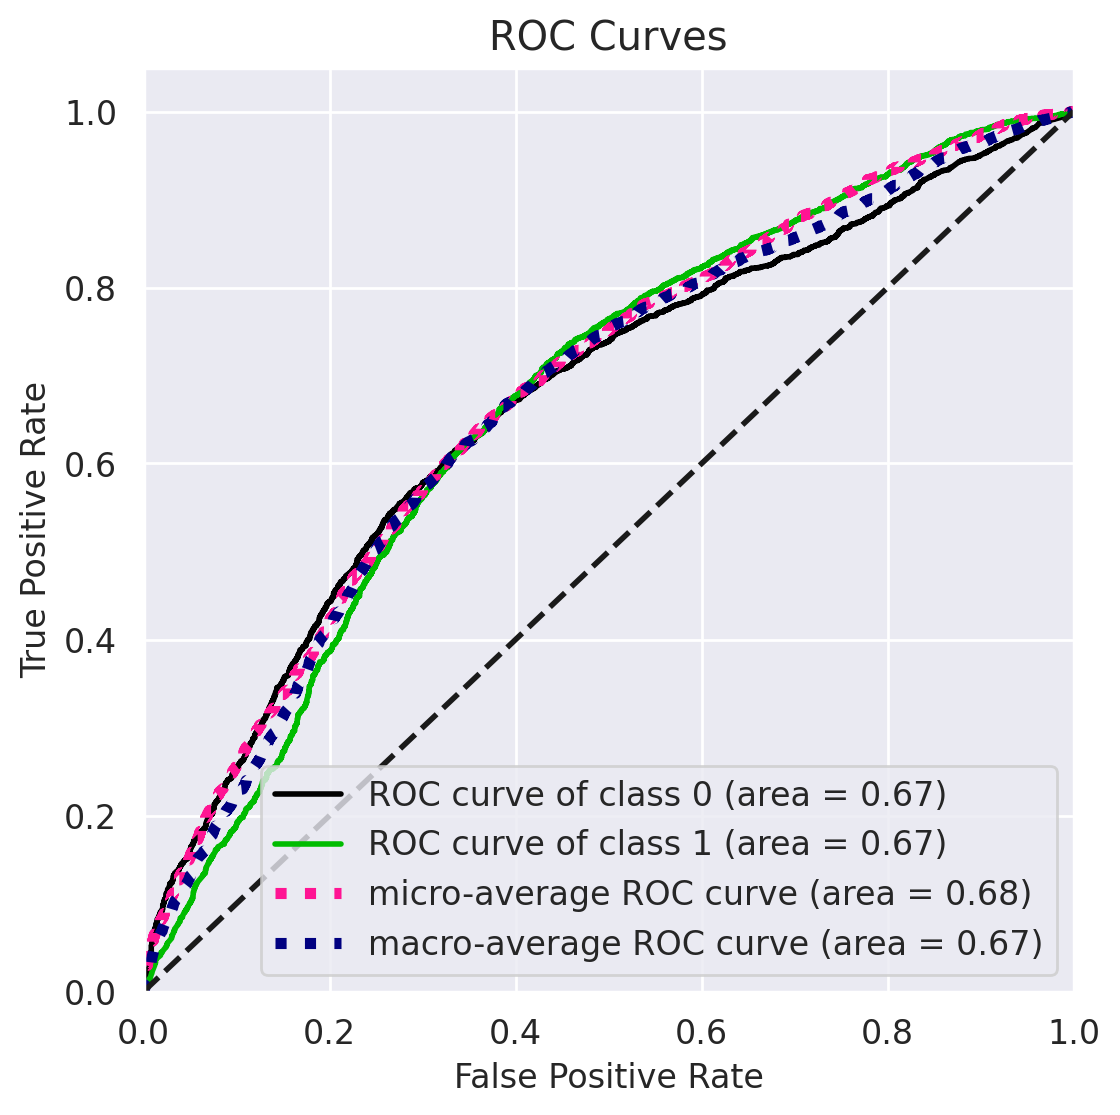

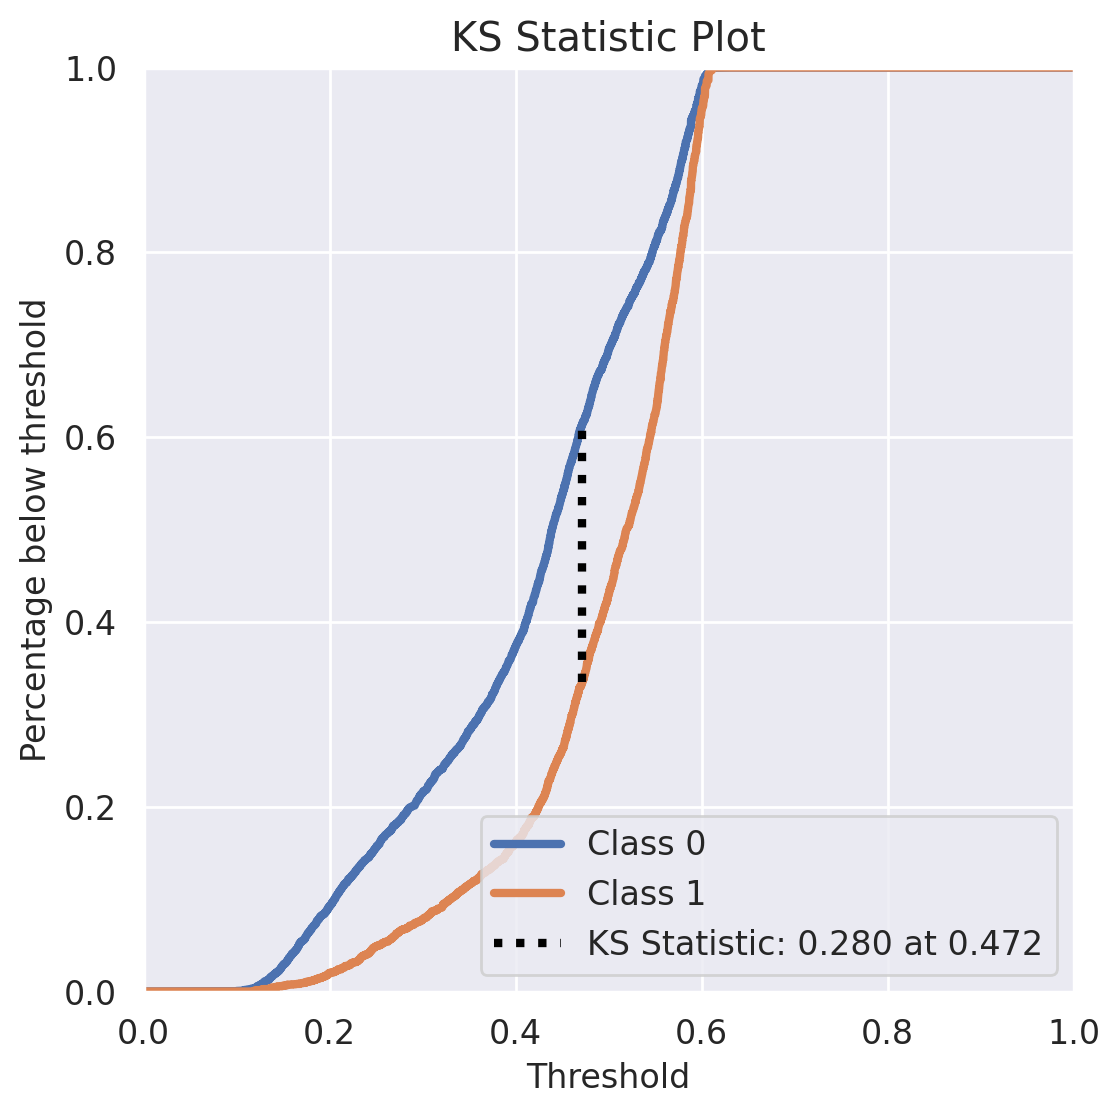

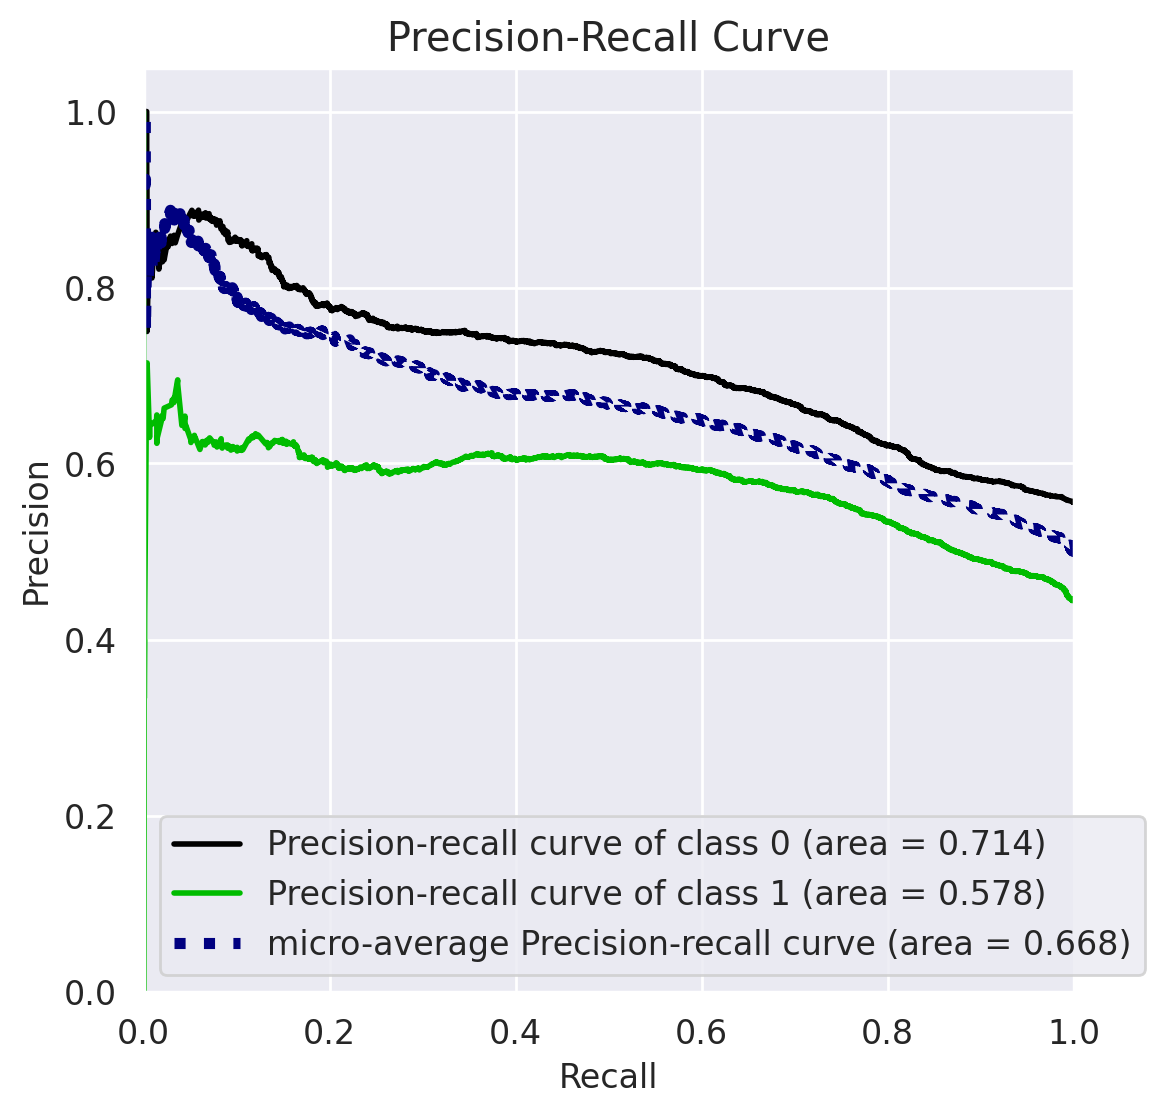

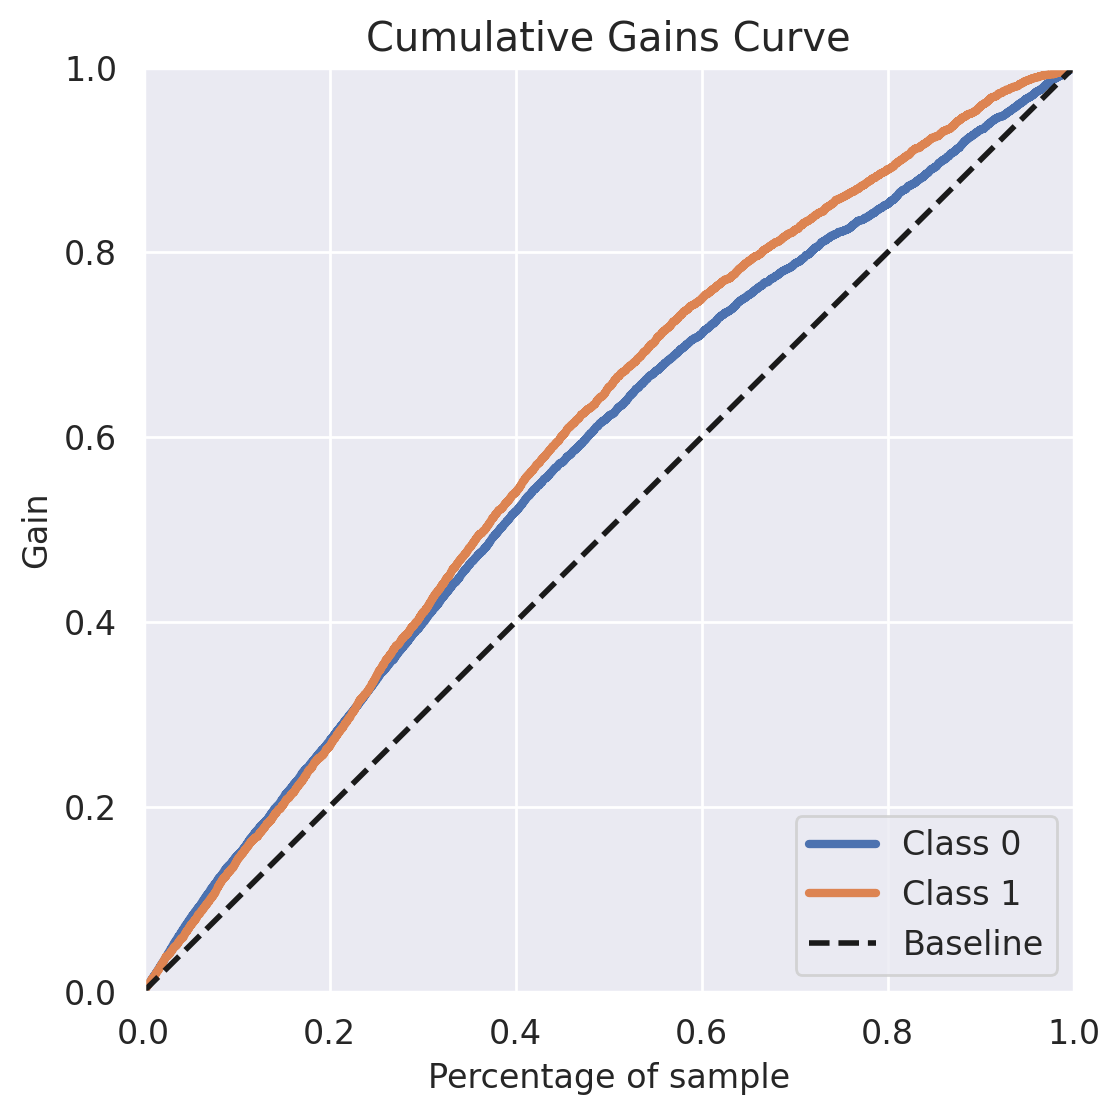

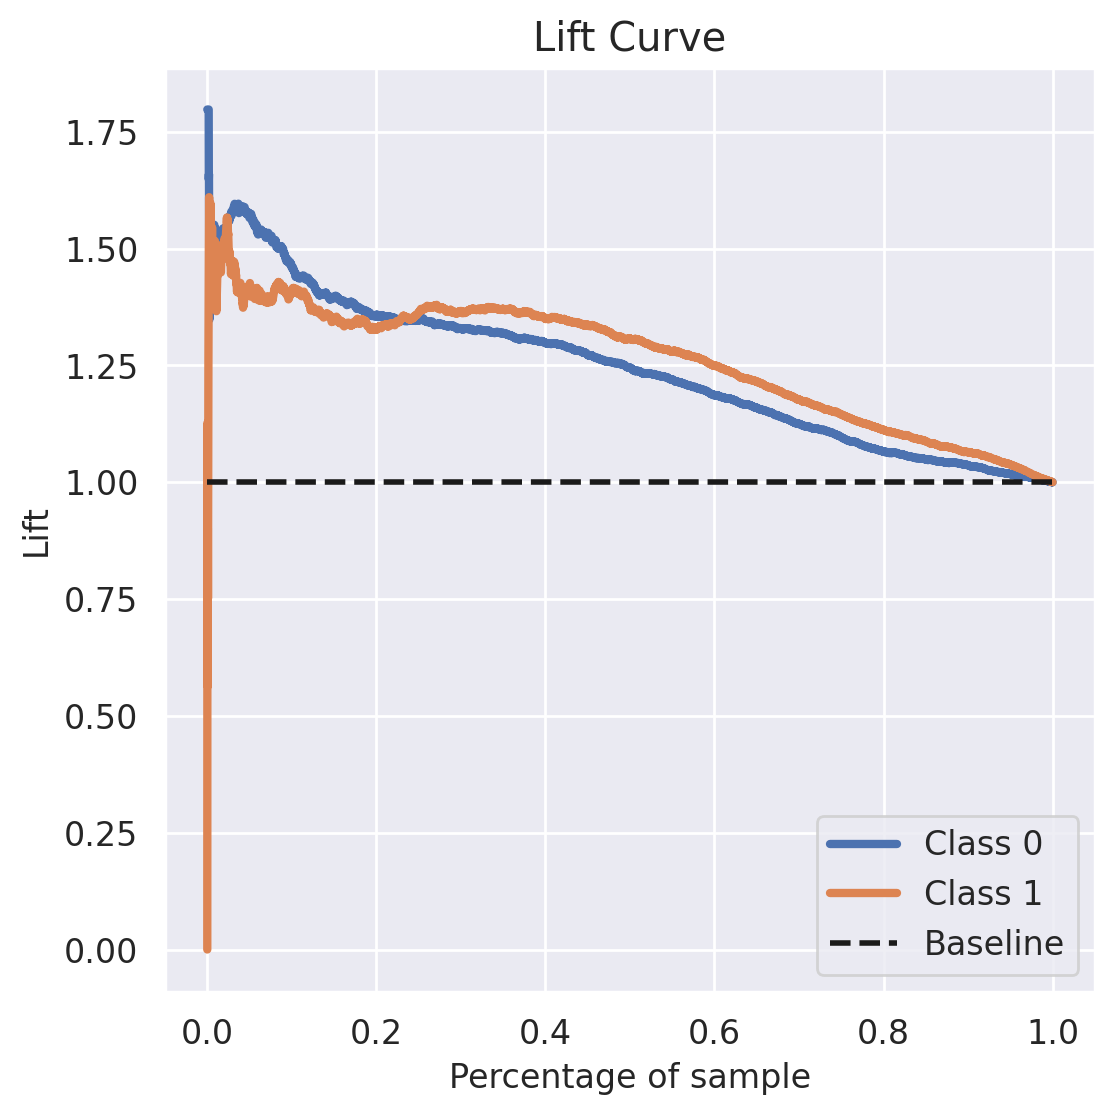

In [283]:
Accuracy, Precision, Recall, F1, auc_score, y_pred, y_prob = evaluationMetricsGCV(x_test, y_test, logr_model)
model_stats = model_stats.append({"Model": "Logistic model",
                                    "Accuracy": Accuracy,
                                    "Precision": Precision,
                                    "Recall": Recall,
                                    "F1-Score": F1,
                                    "AUC-Score": auc_score}, ignore_index=True)


In [284]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0  Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244

In [221]:
model_stats.to_markdown()

'|    | Model          |   Accuracy |   Precision |   Recall |   F1-Score |   AUC-Score |\n|---:|:---------------|-----------:|------------:|---------:|-----------:|------------:|\n|  0 | Logistic model |   0.639244 |    0.598039 | 0.570093 |   0.583732 |    0.632244 |'

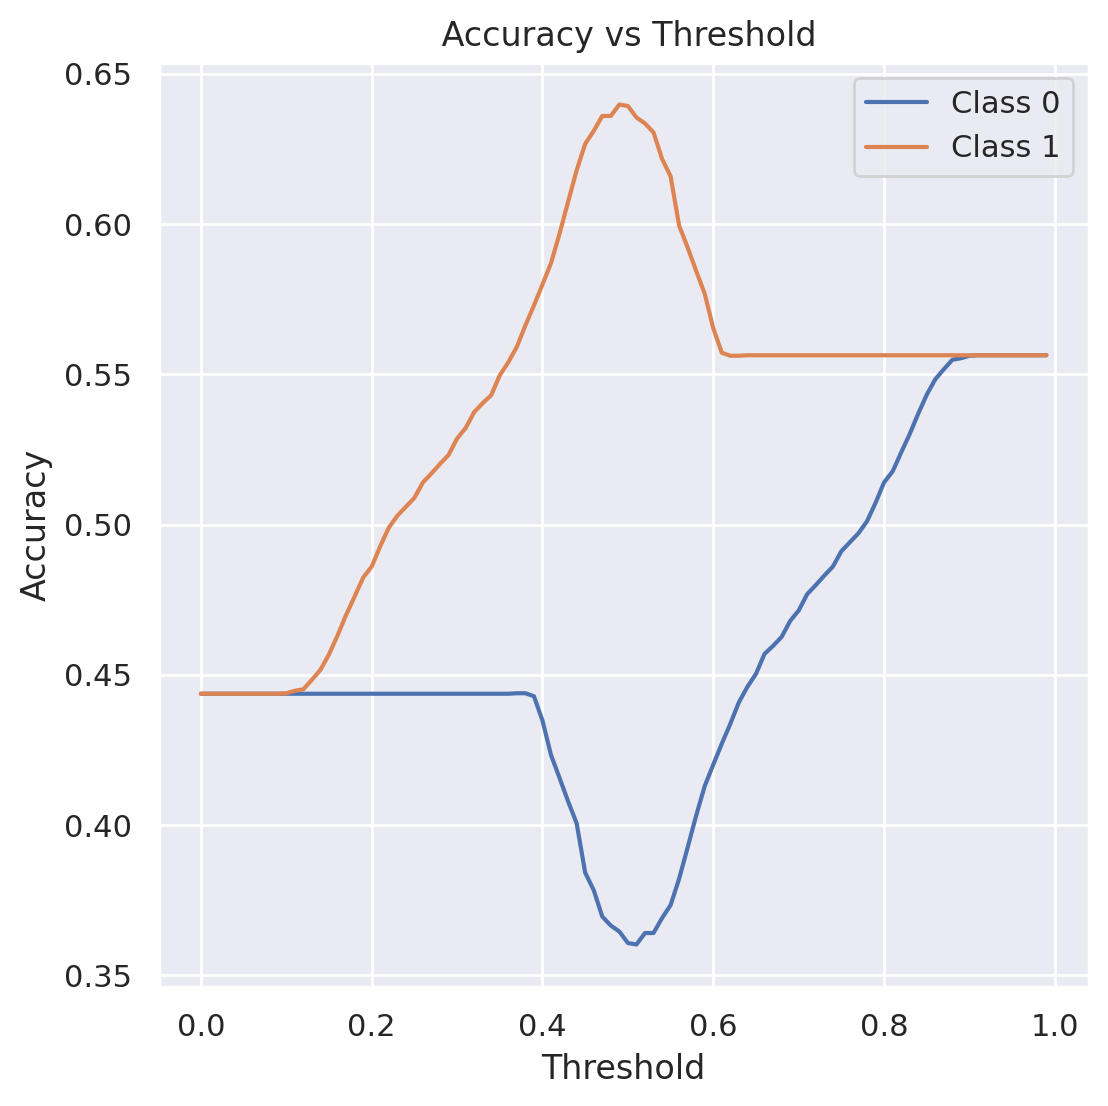

In [239]:
# Display how change the accuracy metric using differnt thresholds
x = []
acc_0 = []
acc_1 = []
for th in np.arange(0.0, 1.0, 0.01):
    y_pred_new_0 = y_prob[:,0] >= th
    y_pred_new_1 = y_prob[:,1] >= th
    acc_0.append(accuracy_score(y_test, y_pred_new_0))
    acc_1.append(accuracy_score(y_test, y_pred_new_1))
    x.append(th)
plt.plot(x, acc_0, label = "Class 0")
plt.plot(x, acc_1, label = "Class 1")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title(" Accuracy vs Threshold")
plt.legend()
plt.show()

### 3.2. Decision Tree Model

#### Hyperparameter Tunning

In [242]:
# GridSearchCV for Decision Tree Model

parameters = {}
parameters['max_depth'] = [i for i in range(1, 11)]
parameters['class_weight'] = [None, 'balanced']
parameters['max_features'] = [i for i in range(1, 8)]
parameters['min_samples_leaf'] = [i for i in range(1, 11)]

#
GS_tree = GridSearchCV(DecisionTreeClassifier(random_state = 1000), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_tree.fit(x_train, y_train)


Fitting 10 folds for each of 1400 candidates, totalling 14000 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1000),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy', verbose=1)

In [243]:
GridSearchResults(GS_tree)

Best parameters: 
 {'class_weight': None, 'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 5}
Best score: 
 0.66344 (+/-0.00662)
All parameters: 
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 7,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1000,
 'splitter': 'best'}


params  mean_test_score  \
554  {'class_weight': None, 'max_depth': 8, 'max_fe...         0.663444   
474  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.663371   
482  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.661808   
485  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.661666   
487  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.661594   
481  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.660883   
483  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.660670   
553  {'class_weight': None, 'max_depth': 8, 'max_fe...         0.660669   
473  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.660385   
480  {'class_weight': None, 'max_depth': 7, 'max_fe...         0.660314   

     std_test_score  rank_test_score  
554        0.006620                1  
474        0.009664                2  
482        0.006527                3  
485        0.008073                4  
487        0.008310                5  
481        0.008289                6  
483        0.007874                7  
553        0.010791                8  
473        0.008892                9  
480        0.009318               10

#### Modeling

In [244]:
dt_model = DecisionTreeClassifier(max_depth=8,max_features=7, min_samples_leaf=5, random_state = 1000);
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=8, max_features=7, min_samples_leaf=5,
                       random_state=1000)

#### Evaluation



Results: 
+++++ Accuracy Score 0.673
+++++ Precision Score 0.647
+++++ Recall Score 0.582
+++++ F1 Score 0.612


              precision    recall  f1-score   support

    No churn       0.69      0.75      0.72      3354
       Churn       0.65      0.58      0.61      2675

    accuracy                           0.67      6029
   macro avg       0.67      0.66      0.67      6029
weighted avg       0.67      0.67      0.67      6029

+++++ AUC (Area under the ROC Curve) : 0.664





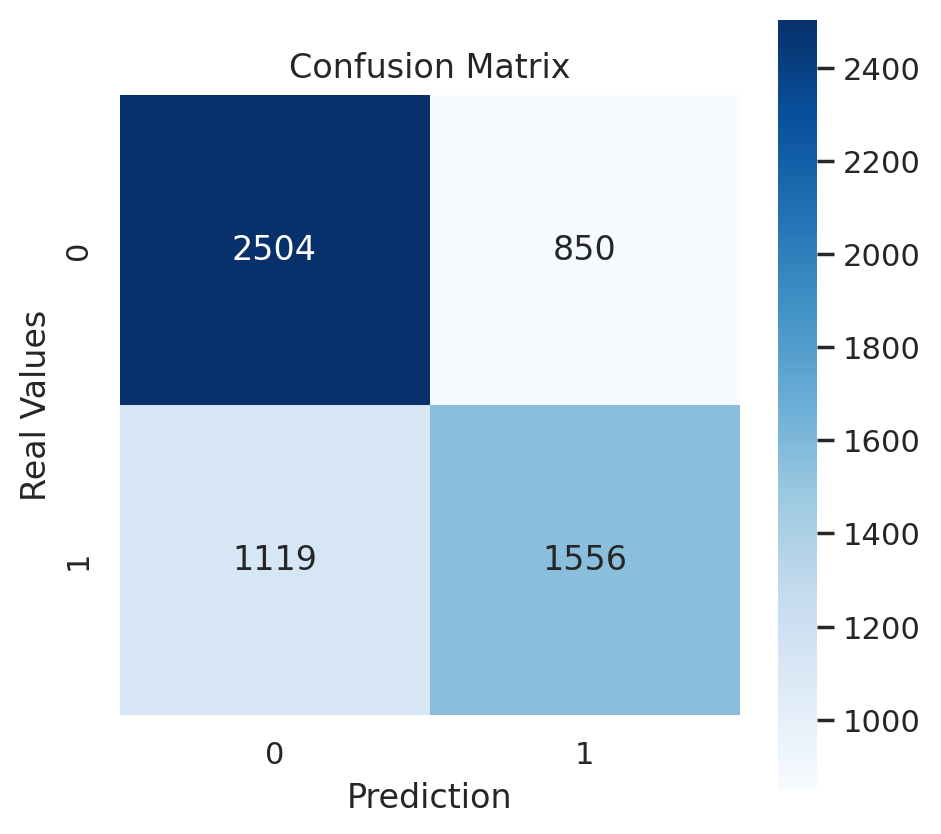

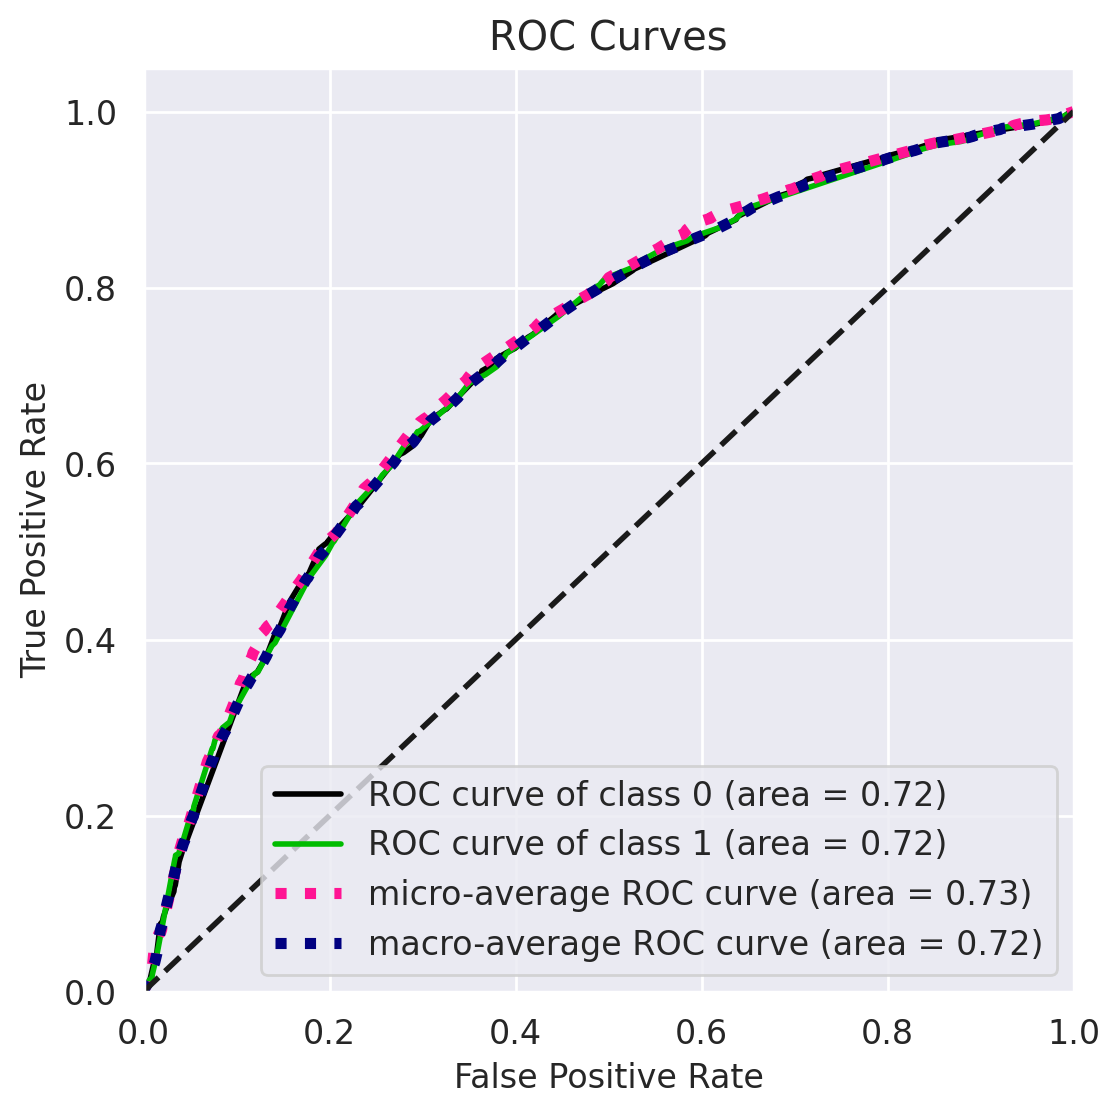

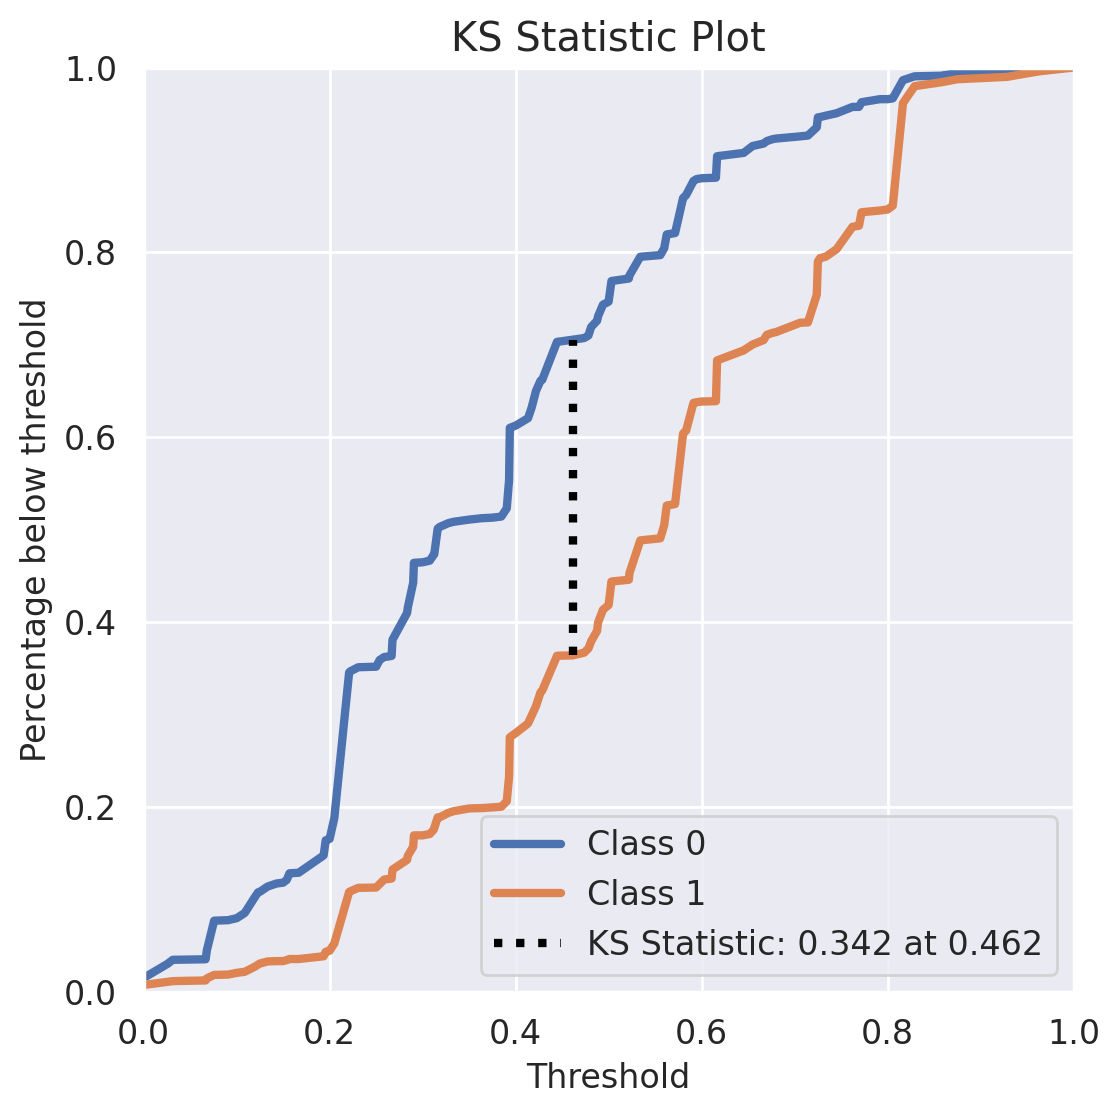

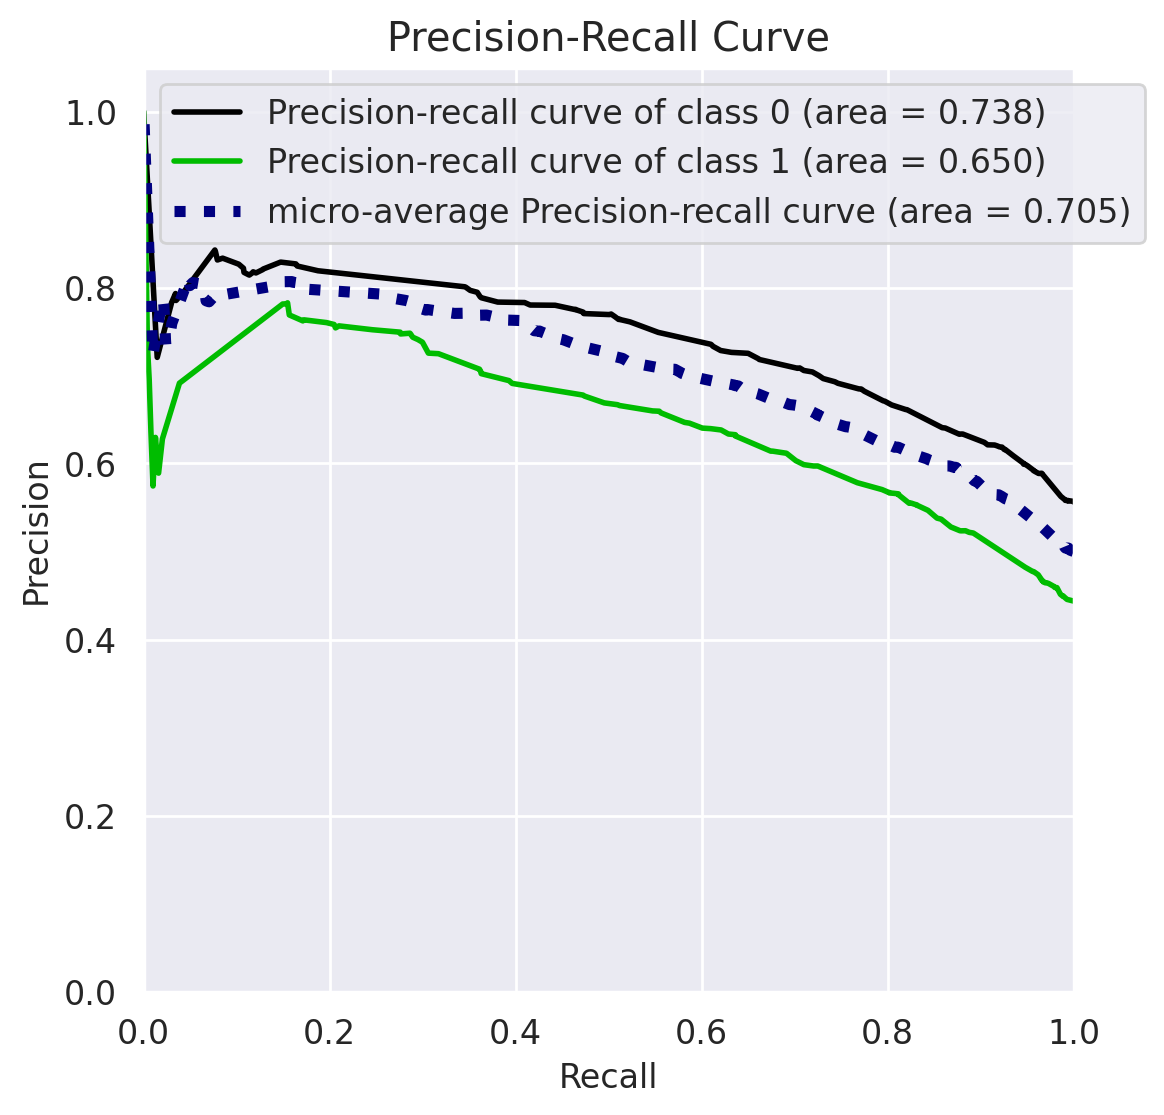

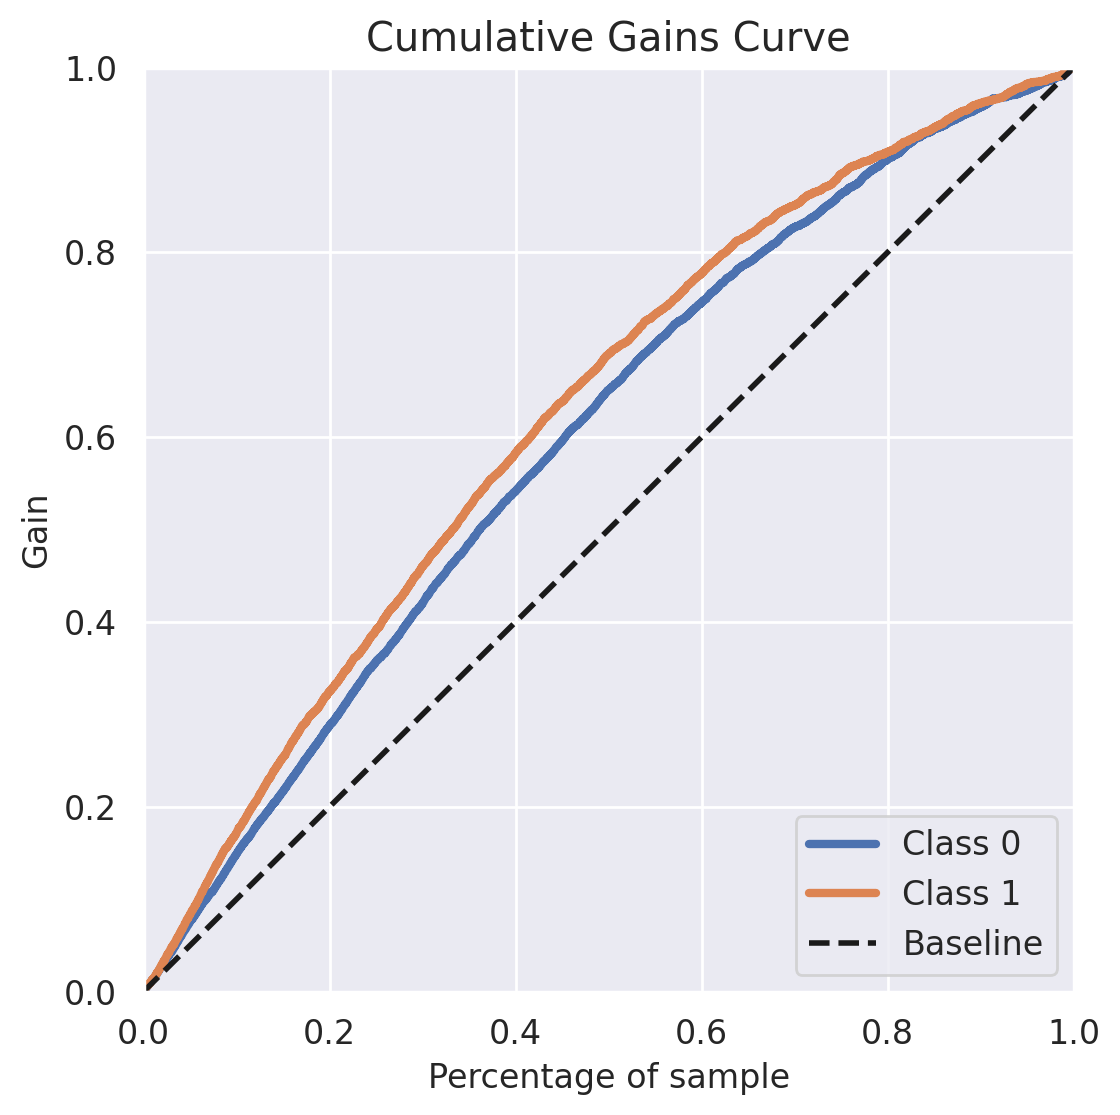

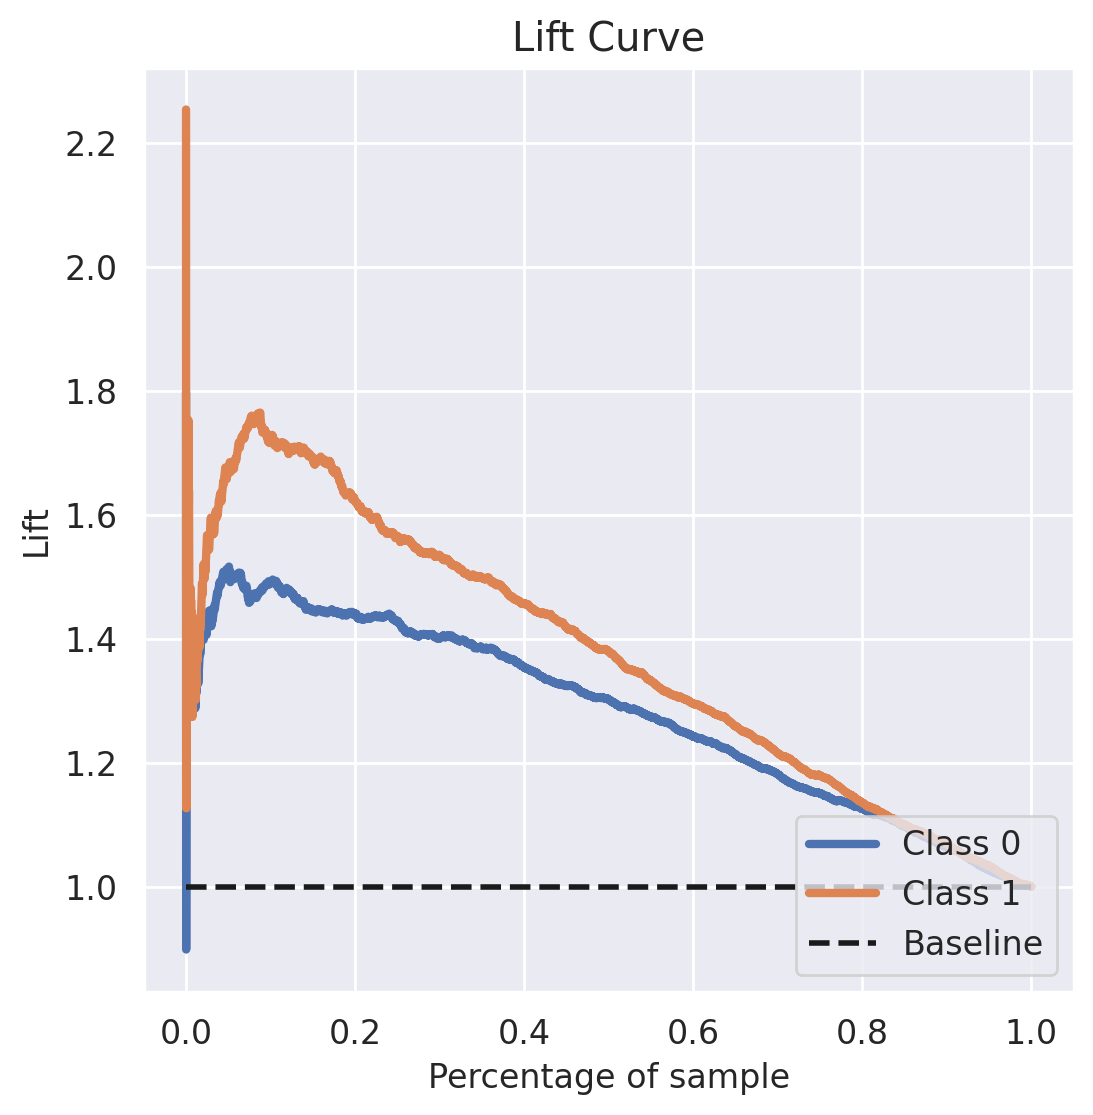

In [285]:
Accuracy, Precision, Recall, F1, auc_score, y_pred, y_prob = evaluationMetricsGCV(x_test, y_test, dt_model)
model_stats = model_stats.append({"Model": "Decision Tree model",
                                    "Accuracy": Accuracy,
                                    "Precision": Precision,
                                    "Recall": Recall,
                                    "F1-Score": F1,
                                    "AUC-Score": auc_score}, ignore_index=True)


In [286]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0       Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244
1  Decision Tree model  0.673412   0.646717  0.581682  0.612478   0.664127

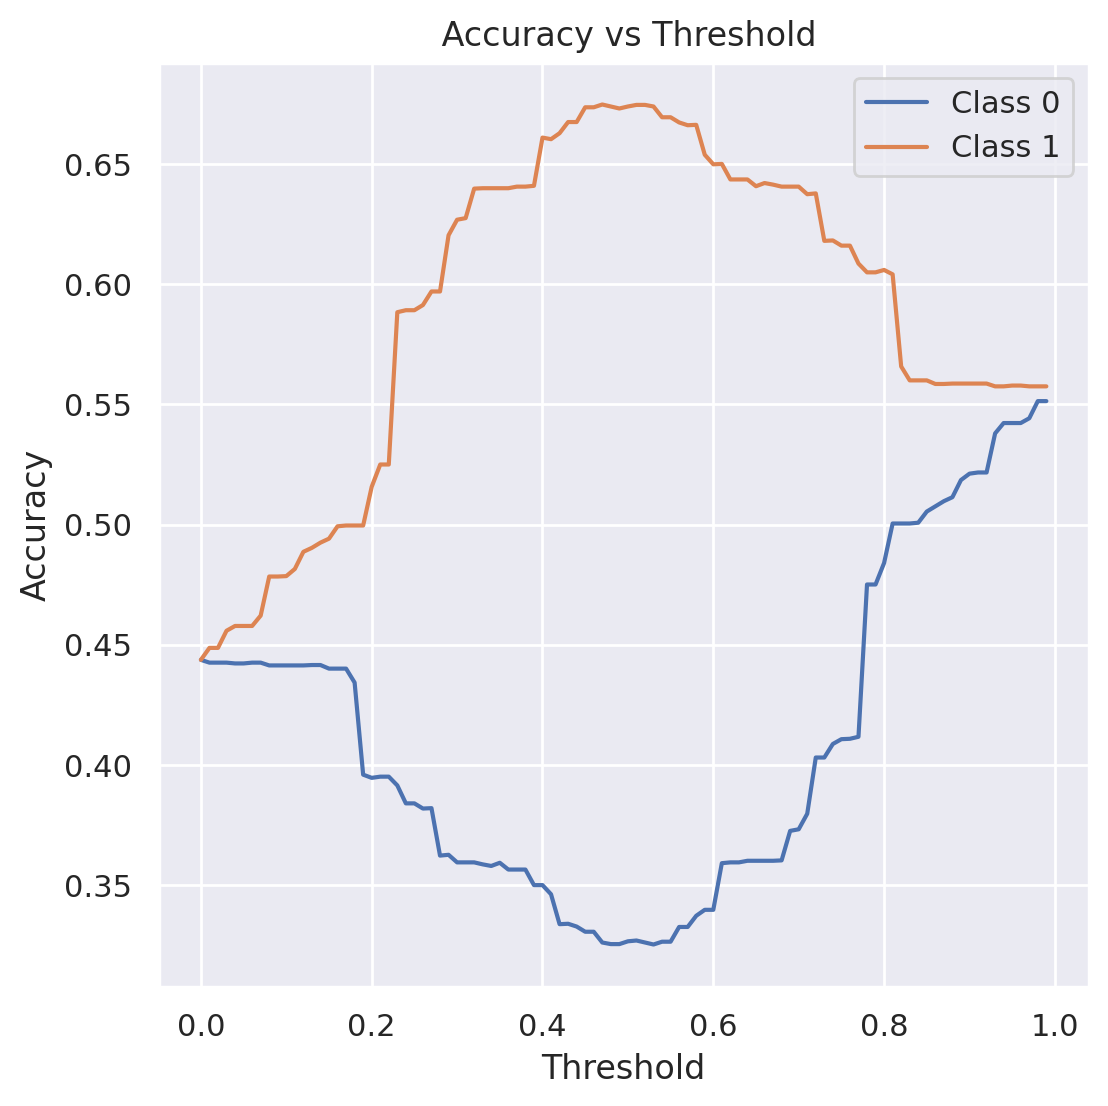

In [247]:
# Display how change the accuracy metric using differnt thresholds
x = []
acc_0 = []
acc_1 = []
for th in np.arange(0.0, 1.0, 0.01):
    y_pred_new_0 = y_prob[:,0] >= th
    y_pred_new_1 = y_prob[:,1] >= th
    acc_0.append(accuracy_score(y_test, y_pred_new_0))
    acc_1.append(accuracy_score(y_test, y_pred_new_1))
    x.append(th)
plt.plot(x, acc_0, label = "Class 0")
plt.plot(x, acc_1, label = "Class 1")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title(" Accuracy vs Threshold")
plt.legend()
plt.show()

### 3.3. SVM Model

#### Hyperparameters Tuning

In [250]:
# GridSearchCV for SVM

parameters = {}
parameters['C'] = [10e-2, 1, 100]
parameters['kernel'] = ['linear','poly', 'rbf']
#parameters['gamma'] = np.arange(0.01, 0.4, 0.1)


#
GS_SVM = GridSearchCV(SVC(random_state = 1000, probability=True), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_SVM.fit(x_train, y_train)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=1000),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 100],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy', verbose=1)

In [251]:
GridSearchResults(GS_SVM)

Best parameters: 
 {'C': 1, 'kernel': 'rbf'}
Best score: 
 0.64545 (+/-0.01170)
All parameters: 
{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 1000,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


params  mean_test_score  std_test_score  \
5       {'C': 1, 'kernel': 'rbf'}         0.645455        0.011701   
7    {'C': 100, 'kernel': 'poly'}         0.644317        0.010408   
8     {'C': 100, 'kernel': 'rbf'}         0.643818        0.012859   
4      {'C': 1, 'kernel': 'poly'}         0.639838        0.010713   
2     {'C': 0.1, 'kernel': 'rbf'}         0.637066        0.013727   
1    {'C': 0.1, 'kernel': 'poly'}         0.632587        0.010276   
0  {'C': 0.1, 'kernel': 'linear'}         0.612112        0.012761   
6  {'C': 100, 'kernel': 'linear'}         0.612041        0.013000   
3    {'C': 1, 'kernel': 'linear'}         0.611970        0.012831   

   rank_test_score  
5                1  
7                2  
8                3  
4                4  
2                5  
1                6  
0                7  
6                8  
3                9

In [253]:
# GridSearchCV for SVM

parameters = {}
parameters['C'] = [1]
parameters['kernel'] = ['rbf']
parameters['gamma'] = np.arange(0.01, 0.4, 0.1)


#
GS_SVM_1 = GridSearchCV(SVC(random_state = 1000, probability=True), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_SVM_1.fit(x_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=1000),
             n_jobs=-1,
             param_grid={'C': [1], 'gamma': array([0.01, 0.11, 0.21, 0.31]),
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [254]:
GridSearchResults(GS_SVM_1)

Best parameters: 
 {'C': 1, 'gamma': 0.31000000000000005, 'kernel': 'rbf'}
Best score: 
 0.64595 (+/-0.01222)
All parameters: 
{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.31000000000000005,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 1000,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


params  mean_test_score  \
3  {'C': 1, 'gamma': 0.31000000000000005, 'kernel...         0.645951   
2  {'C': 1, 'gamma': 0.21000000000000002, 'kernel...         0.644957   
1           {'C': 1, 'gamma': 0.11, 'kernel': 'rbf'}         0.642895   
0           {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}         0.627255   

   std_test_score  rank_test_score  
3        0.012222                1  
2        0.011892                2  
1        0.011930                3  
0        0.009315                4

#### Modeling

In [255]:
svm_model = SVC(C=1, gamma = 0.31, kernel = 'rbf', random_state = 1000, probability=True);
svm_model.fit(x_train, y_train)

SVC(C=1, gamma=0.31, probability=True, random_state=1000)

#### Evaluation



Results: 
+++++ Accuracy Score 0.664
+++++ Precision Score 0.631
+++++ Recall Score 0.587
+++++ F1 Score 0.608


              precision    recall  f1-score   support

    No churn       0.69      0.73      0.71      3354
       Churn       0.63      0.59      0.61      2675

    accuracy                           0.66      6029
   macro avg       0.66      0.66      0.66      6029
weighted avg       0.66      0.66      0.66      6029

+++++ AUC (Area under the ROC Curve) : 0.656





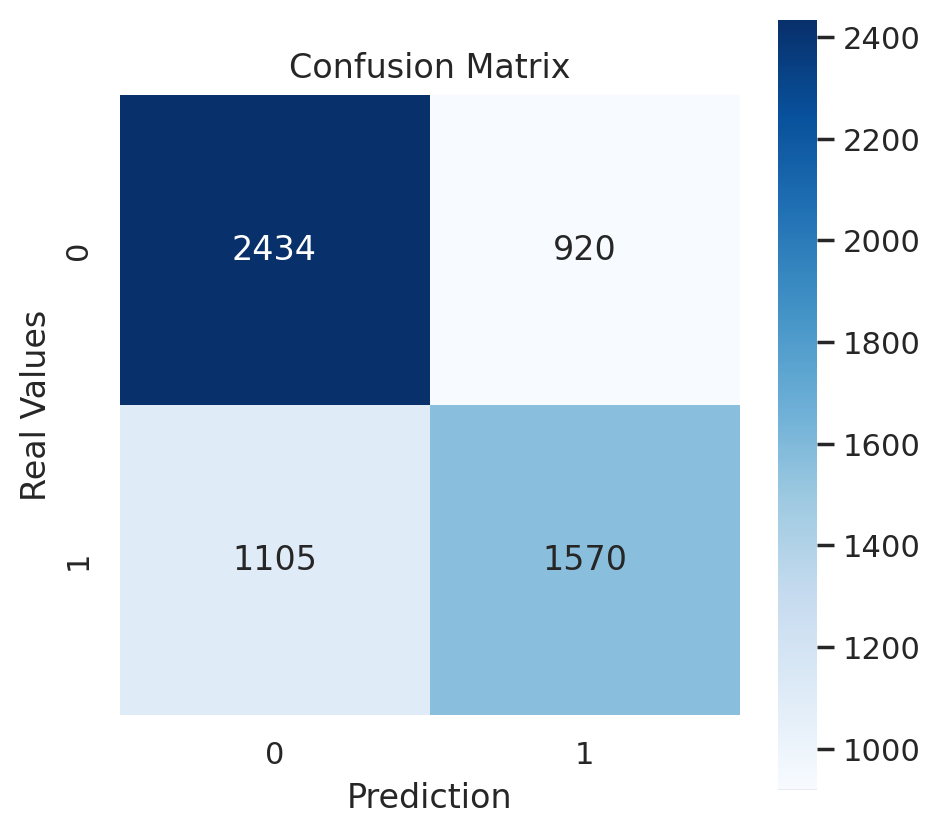

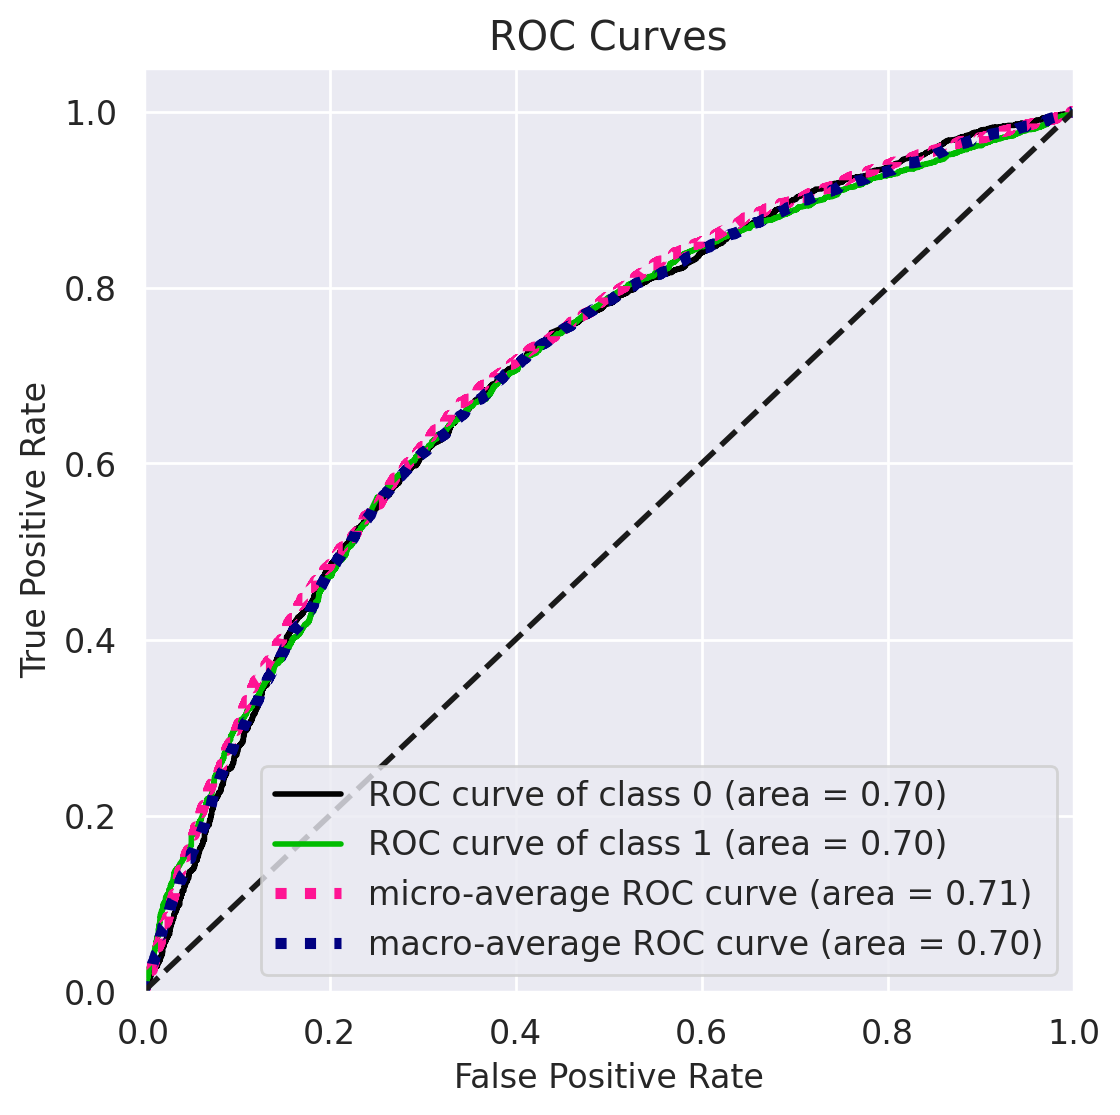

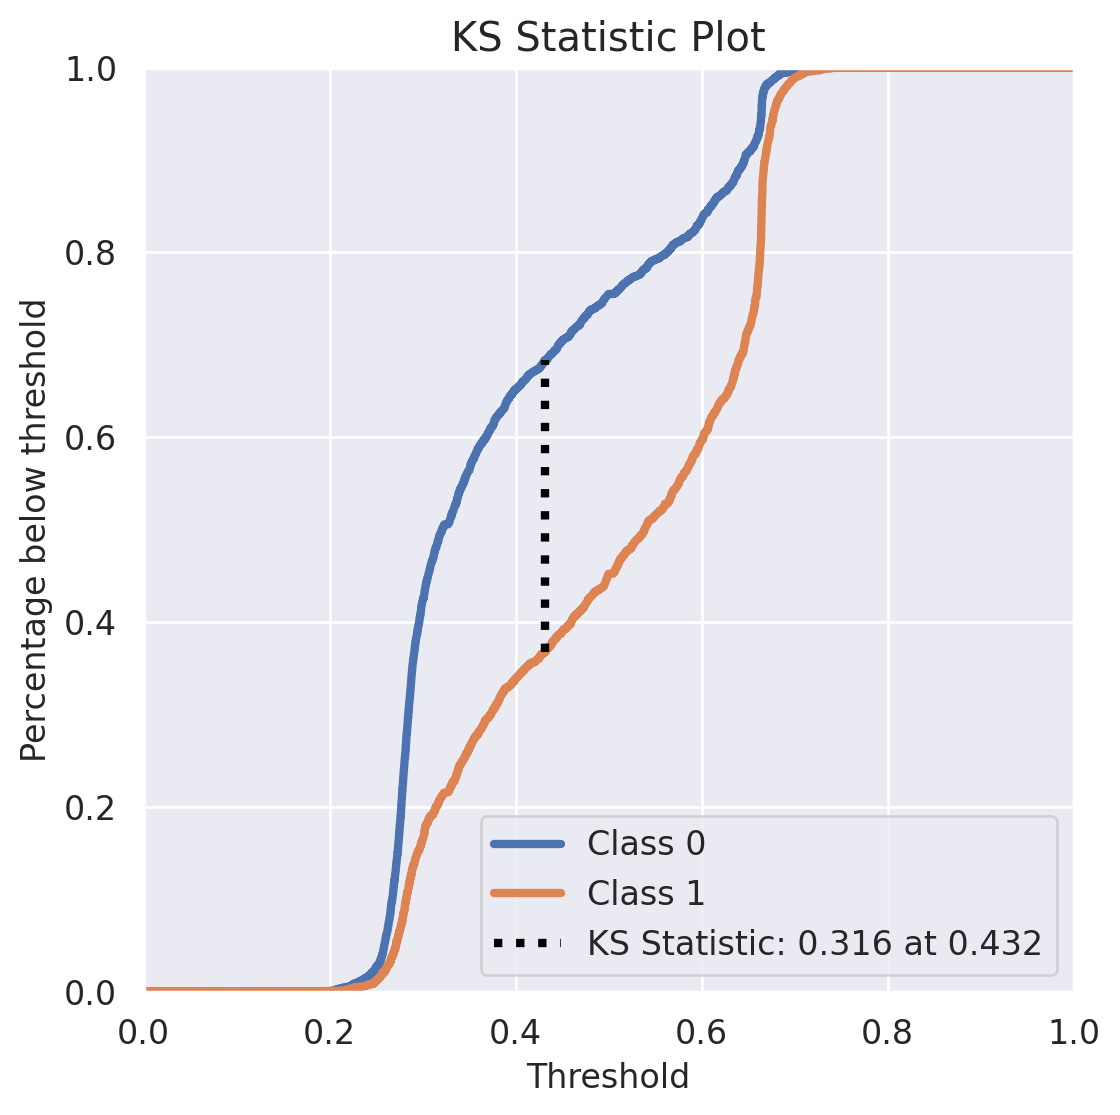

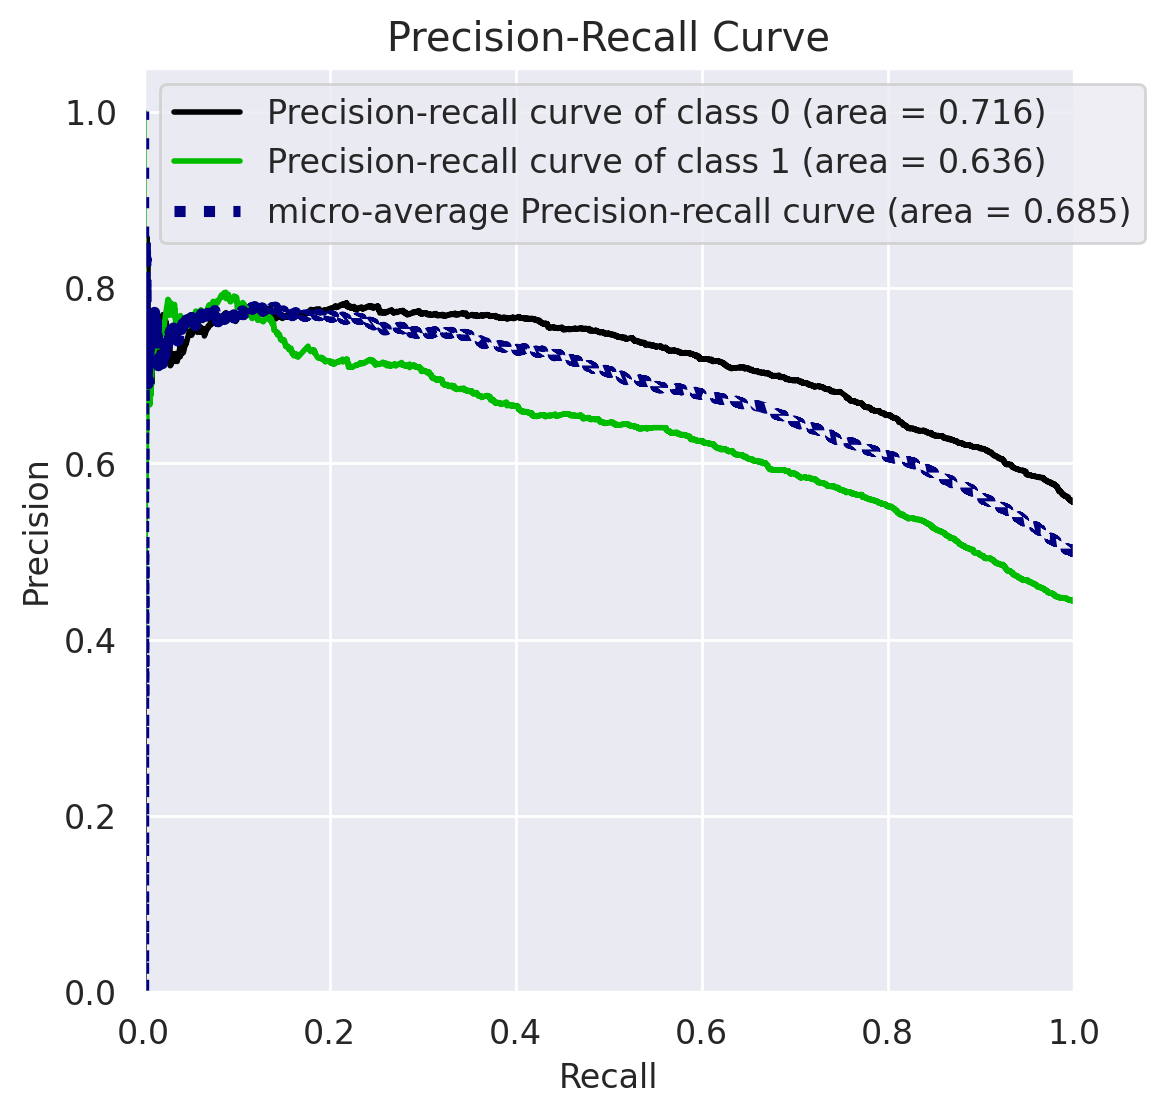

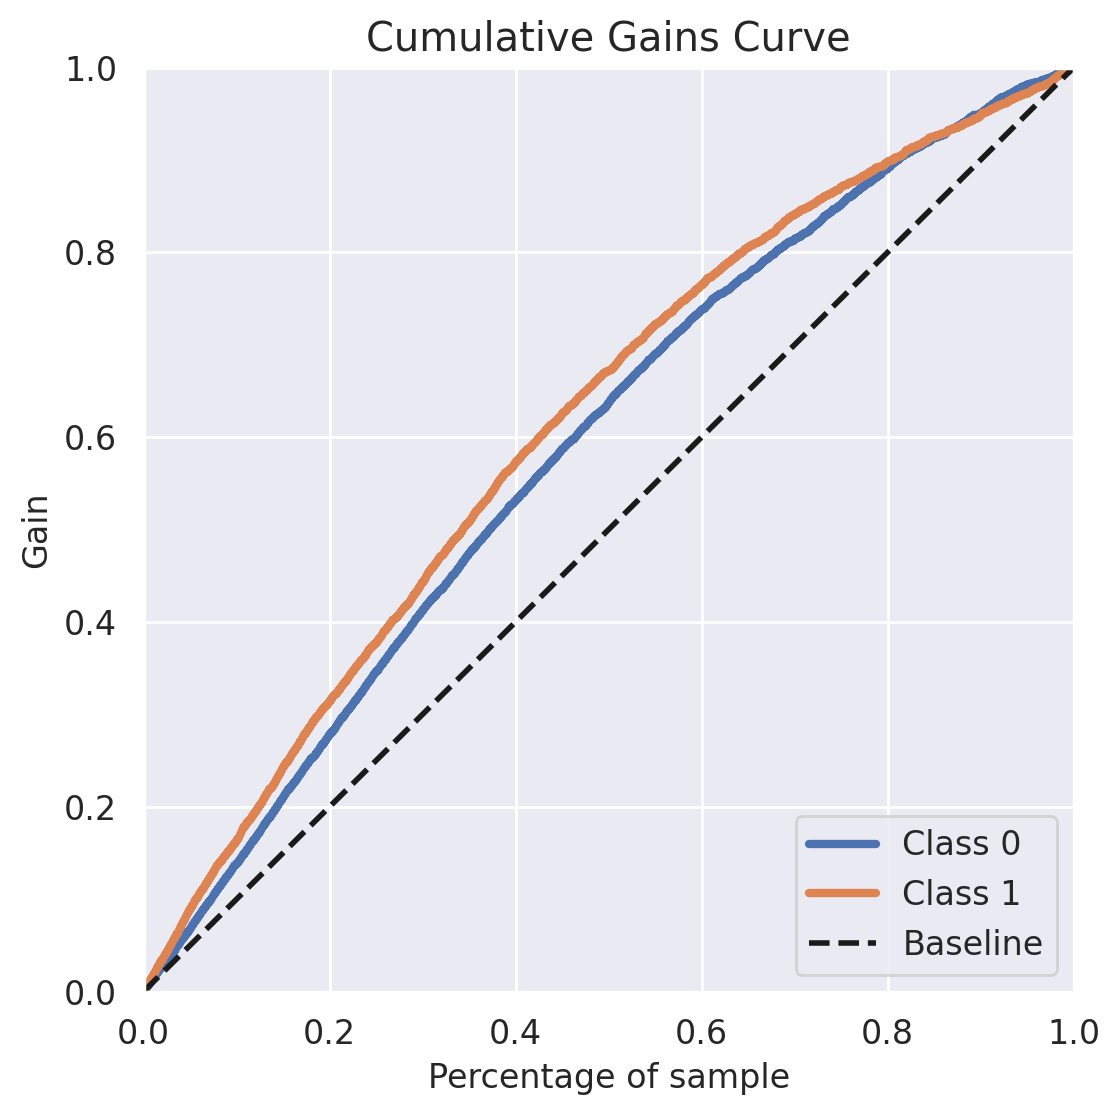

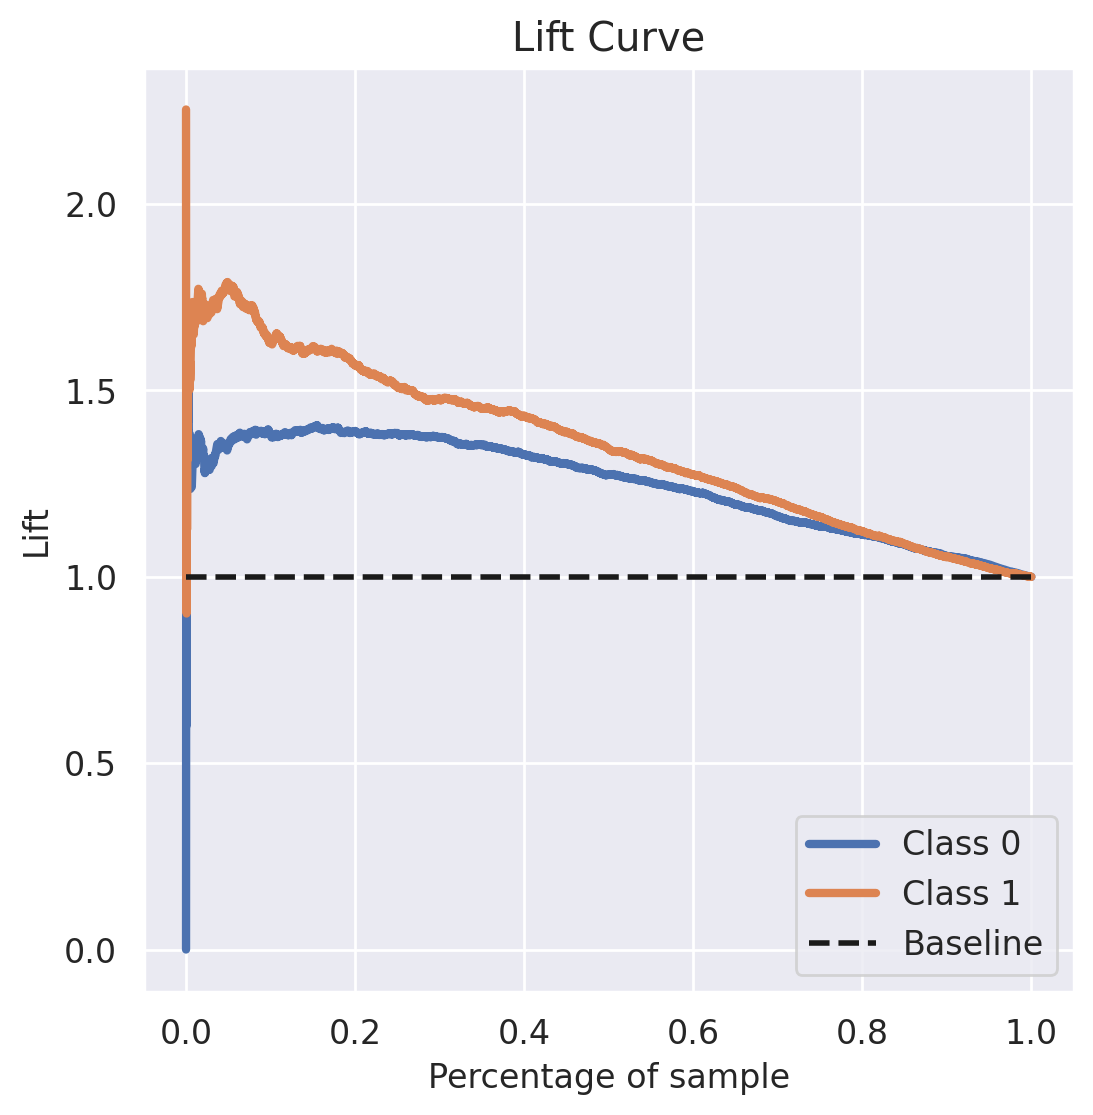

In [287]:
Accuracy, Precision, Recall, F1, auc_score, y_pred, y_prob = evaluationMetricsGCV(x_test, y_test, svm_model)
model_stats = model_stats.append({"Model": "SVM model",
                                    "Accuracy": Accuracy,
                                    "Precision": Precision,
                                    "Recall": Recall,
                                    "F1-Score": F1,
                                    "AUC-Score": auc_score}, ignore_index=True)

In [288]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0       Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244
1  Decision Tree model  0.673412   0.646717  0.581682  0.612478   0.664127
2            SVM model  0.664123   0.630522  0.586916  0.607938   0.656308

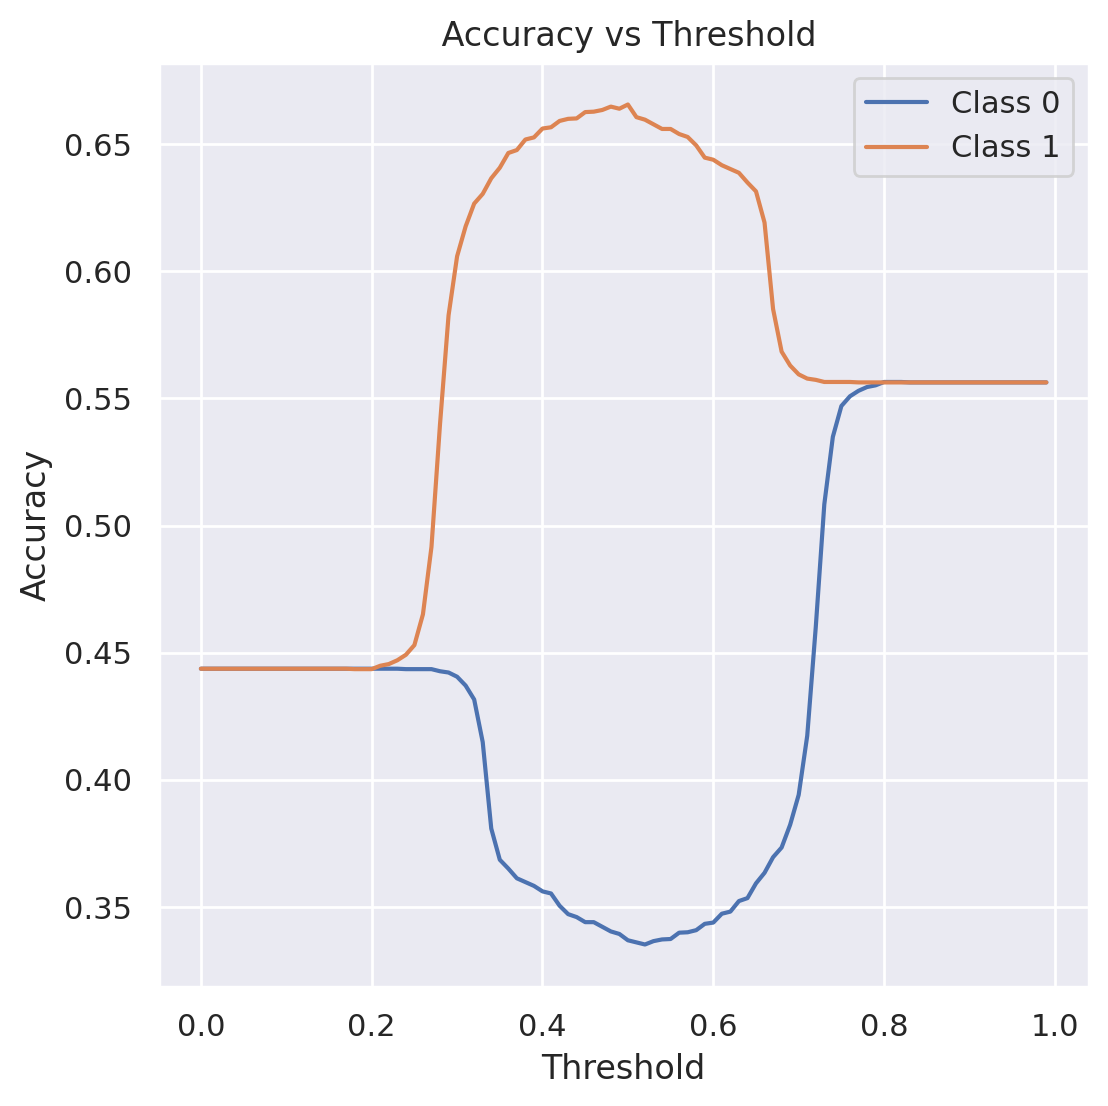

In [289]:
# Display how change the accuracy metric using differnt thresholds
x = []
acc_0 = []
acc_1 = []
for th in np.arange(0.0, 1.0, 0.01):
    y_pred_new_0 = y_prob[:,0] >= th
    y_pred_new_1 = y_prob[:,1] >= th
    acc_0.append(accuracy_score(y_test, y_pred_new_0))
    acc_1.append(accuracy_score(y_test, y_pred_new_1))
    x.append(th)
plt.plot(x, acc_0, label = "Class 0")
plt.plot(x, acc_1, label = "Class 1")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title(" Accuracy vs Threshold")
plt.legend()
plt.show()

### 3.4. Random Forest Model

#### Hyperparameters Tuning

1. Finding n_estimators and max_depth

In [261]:
# GridSearchCV for logistic Regression

parameters = {}
#parameters['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters['n_estimators'] = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1100, 1000, 1100, 1200, 1300]
#parameters['criterion'] = ['entropy', 'gini']
parameters['max_depth'] = [7, 8, 9, 10, 11, 12, 13, 14, 15, None]

#
GS_rf_0 = GridSearchCV(RandomForestClassifier(), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_rf_0.fit(x_train, y_train)


Fitting 10 folds for each of 140 candidates, totalling 1400 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12, 13, 14, 15, None],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1100, 1000, 1100, 1200,
                                          1300]},
             scoring='accuracy', verbose=1)

In [262]:
GridSearchResults(GS_rf_0)

Best parameters: 
 {'max_depth': 9, 'n_estimators': 200}
Best score: 
 0.66863 (+/-0.00920)
All parameters: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


params  mean_test_score  std_test_score  \
29   {'max_depth': 9, 'n_estimators': 200}         0.668632        0.009199   
8    {'max_depth': 7, 'n_estimators': 900}         0.668418        0.009838   
19   {'max_depth': 8, 'n_estimators': 600}         0.668348        0.008300   
10  {'max_depth': 7, 'n_estimators': 1000}         0.668347        0.010234   
49  {'max_depth': 10, 'n_estimators': 800}         0.668064        0.008299   
15   {'max_depth': 8, 'n_estimators': 200}         0.667992        0.008415   
23  {'max_depth': 8, 'n_estimators': 1100}         0.667921        0.008200   
38  {'max_depth': 9, 'n_estimators': 1000}         0.667779        0.007937   
6    {'max_depth': 7, 'n_estimators': 700}         0.667779        0.010037   
28   {'max_depth': 9, 'n_estimators': 100}         0.667566        0.008903   

    rank_test_score  
29                1  
8                 2  
19                3  
10                4  
49                5  
15                6  
23                7  
38                8  
6                 9  
28               10

2. Finding n_estimators and max_depth

In [272]:
# GridSearchCV for logistic Regression

parameters = {}
#parameters['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters['n_estimators'] = [150, 170, 190, 200, 210, 220, 230, 250]
#parameters['criterion'] = ['entropy', 'gini']
parameters['max_depth'] = [9]

#
GS_rf_1 = GridSearchCV(RandomForestClassifier(), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_rf_1.fit(x_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [9],
                         'n_estimators': [150, 170, 190, 200, 210, 220, 230,
                                          250]},
             scoring='accuracy', verbose=1)

In [273]:
GridSearchResults(GS_rf_1)

Best parameters: 
 {'max_depth': 9, 'n_estimators': 170}
Best score: 
 0.66949 (+/-0.00762)
All parameters: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 170,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


params  mean_test_score  std_test_score  \
1  {'max_depth': 9, 'n_estimators': 170}         0.669486        0.007622   
0  {'max_depth': 9, 'n_estimators': 150}         0.668277        0.008659   
5  {'max_depth': 9, 'n_estimators': 220}         0.668135        0.009312   
4  {'max_depth': 9, 'n_estimators': 210}         0.667637        0.007436   
6  {'max_depth': 9, 'n_estimators': 230}         0.667637        0.007191   
7  {'max_depth': 9, 'n_estimators': 250}         0.666642        0.008222   
2  {'max_depth': 9, 'n_estimators': 190}         0.666357        0.008555   
3  {'max_depth': 9, 'n_estimators': 200}         0.665646        0.008500   

   rank_test_score  
1                1  
0                2  
5                3  
4                4  
6                5  
7                6  
2                7  
3                8

3. Finding max_features and criterion

In [274]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters['n_estimators'] = [170]
parameters['criterion'] = ['entropy', 'gini']
parameters['max_depth'] = [10]

#
GS_rf_2 = GridSearchCV(RandomForestClassifier(), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_rf_2.fit(x_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [10],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [170]},
             scoring='accuracy', verbose=1)

In [275]:
GridSearchResults(GS_rf_2)

Best parameters: 
 {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 170}
Best score: 
 0.67204 (+/-0.00904)
All parameters: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 170,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


params  mean_test_score  \
3  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.672045   
7  {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.669201   
0  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.667211   
2  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.666784   
5  {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.666216   
6  {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.666144   
1  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.665575   
4  {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.665220   

   std_test_score  rank_test_score  
3        0.009045                1  
7        0.009980                2  
0        0.008405                3  
2        0.009056                4  
5        0.008496                5  
6        0.008627                6  
1        0.006886                7  
4        0.006385                8

#### Modeling

In [276]:
rf_model = RandomForestClassifier(criterion = 'entropy', max_depth =9, n_estimators = 170, max_features = None)
rf_model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, max_features=None,
                       n_estimators=170)

#### Evaluation



Results: 
+++++ Accuracy Score 0.688
+++++ Precision Score 0.663
+++++ Recall Score 0.603
+++++ F1 Score 0.631


              precision    recall  f1-score   support

    No churn       0.70      0.76      0.73      3354
       Churn       0.66      0.60      0.63      2675

    accuracy                           0.69      6029
   macro avg       0.68      0.68      0.68      6029
weighted avg       0.69      0.69      0.69      6029

+++++ AUC (Area under the ROC Curve) : 0.679





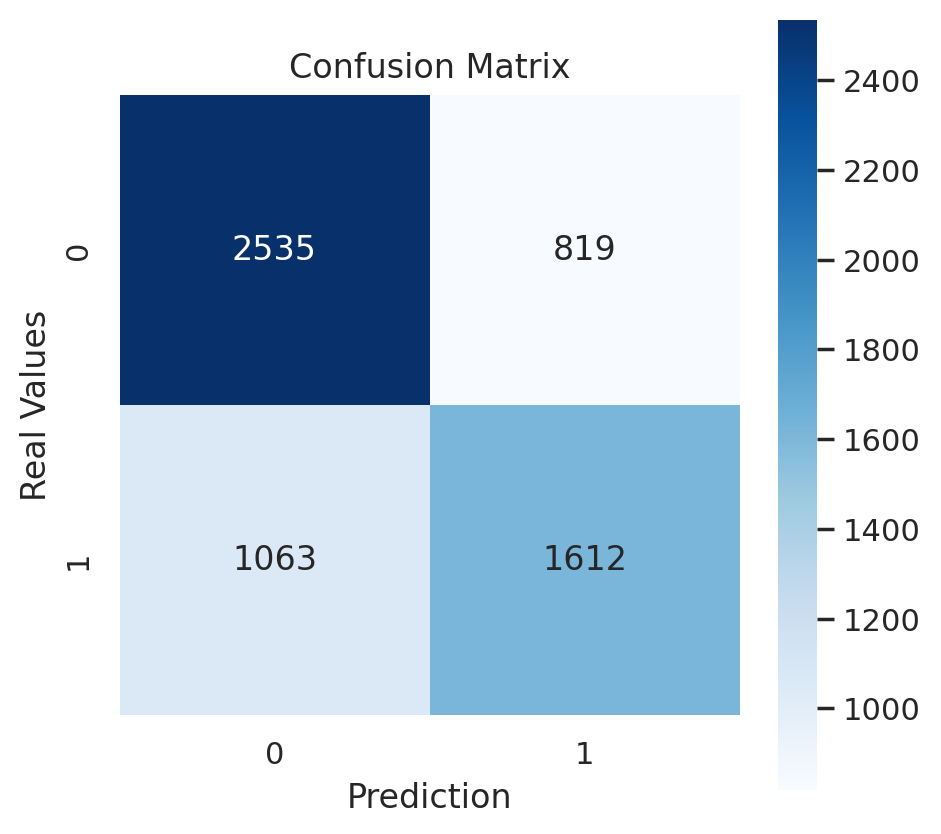

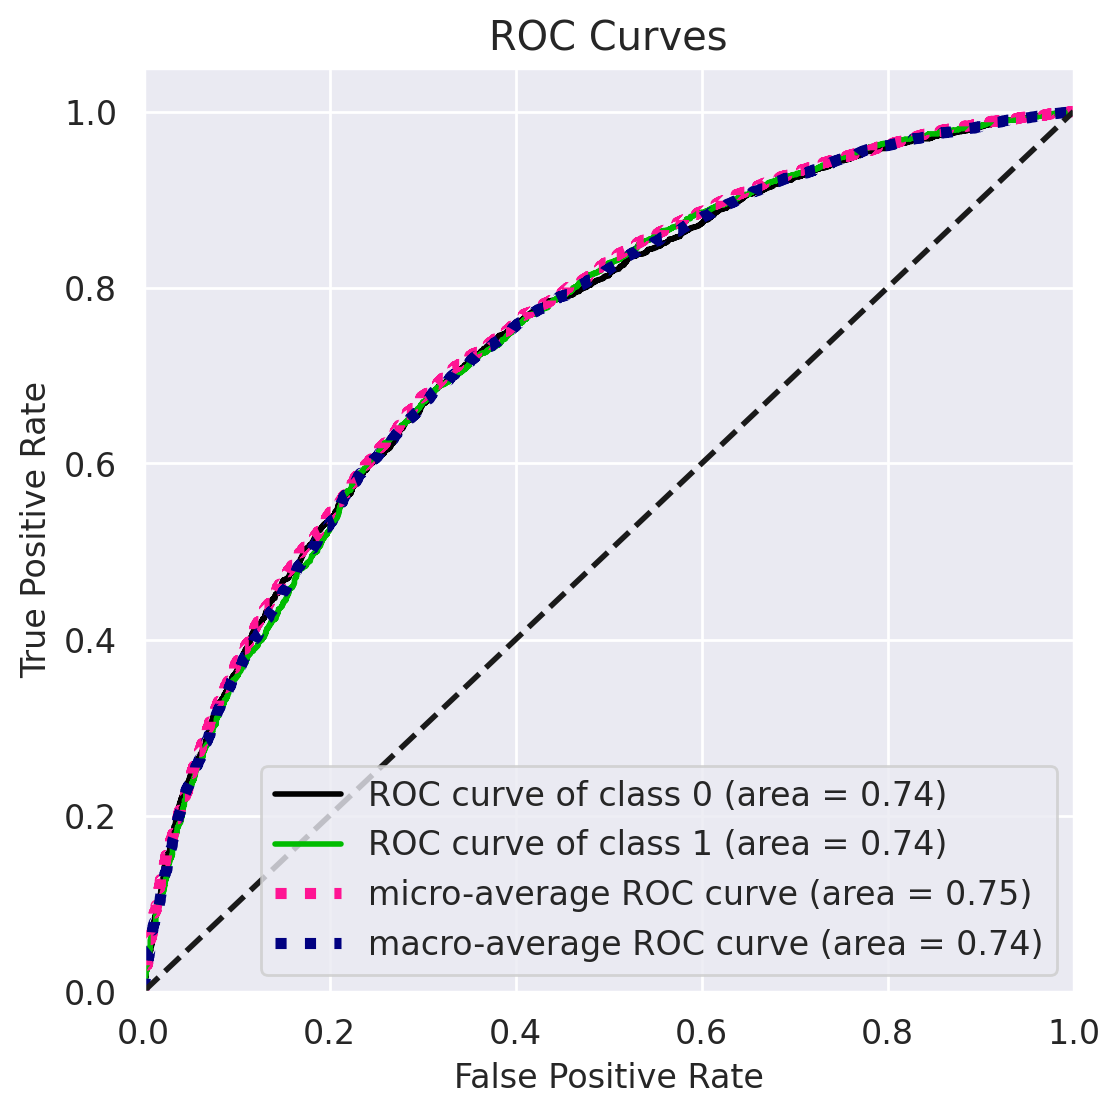

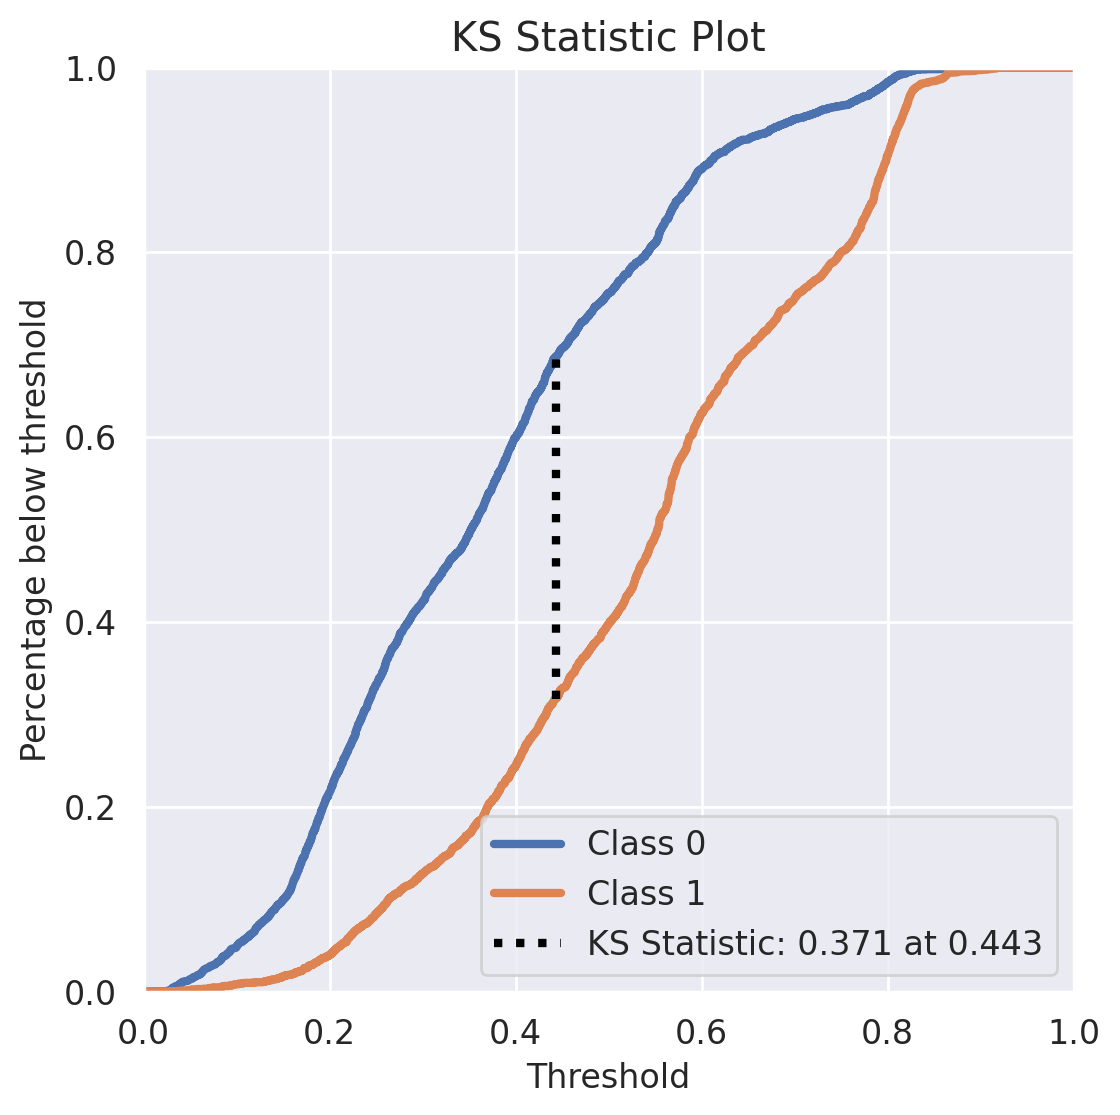

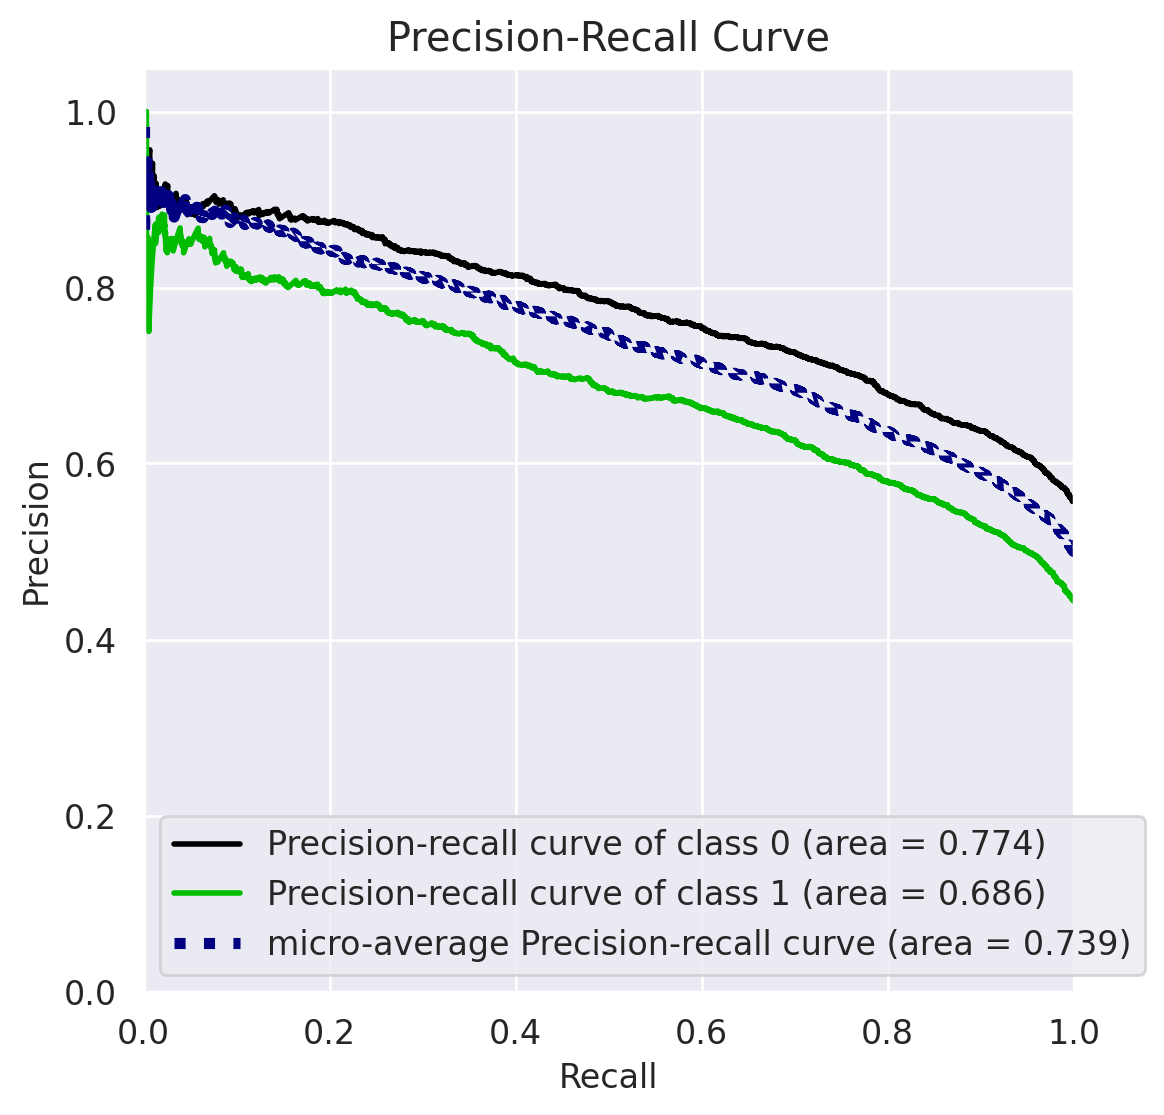

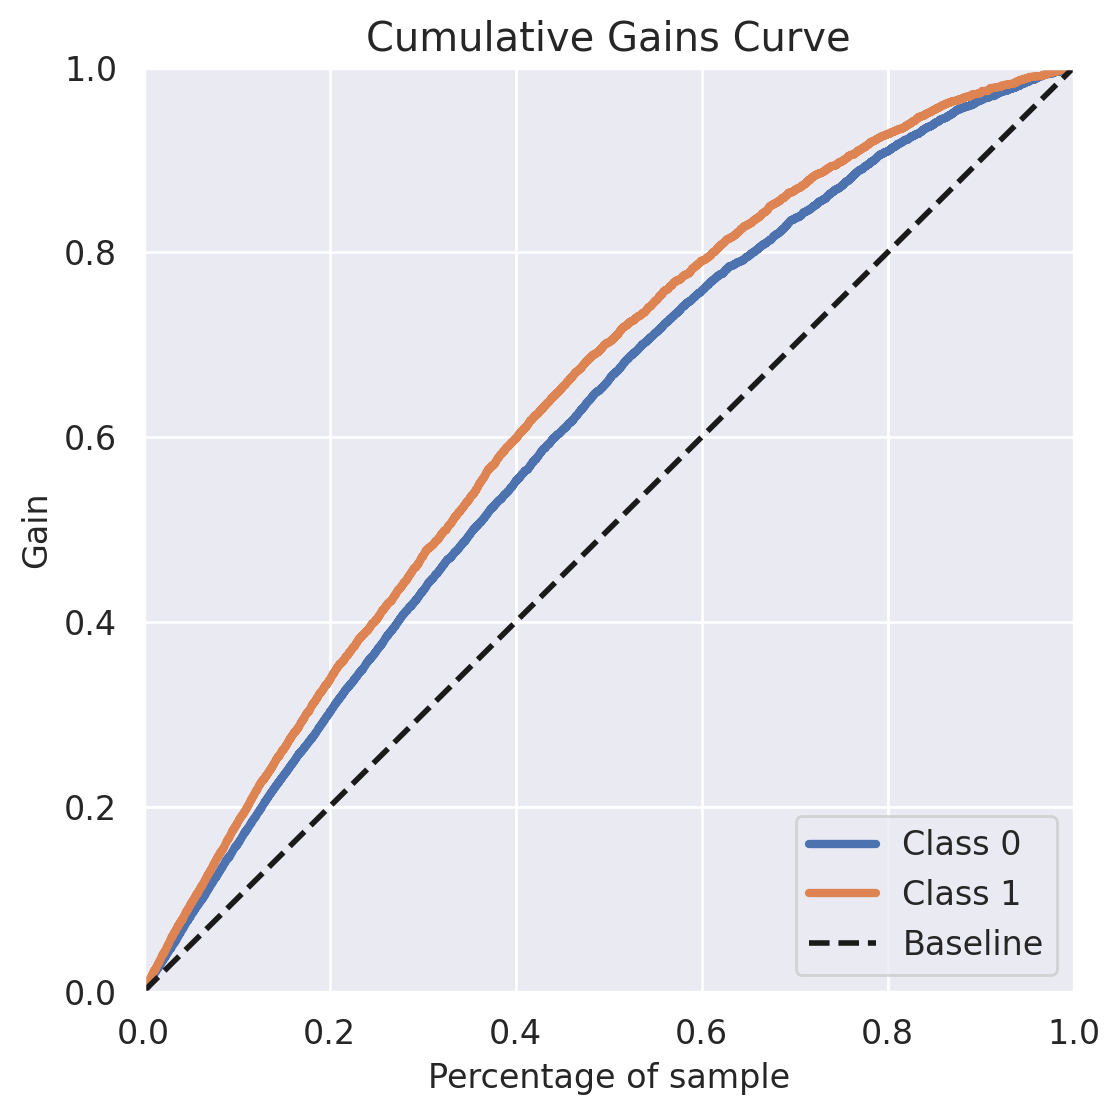

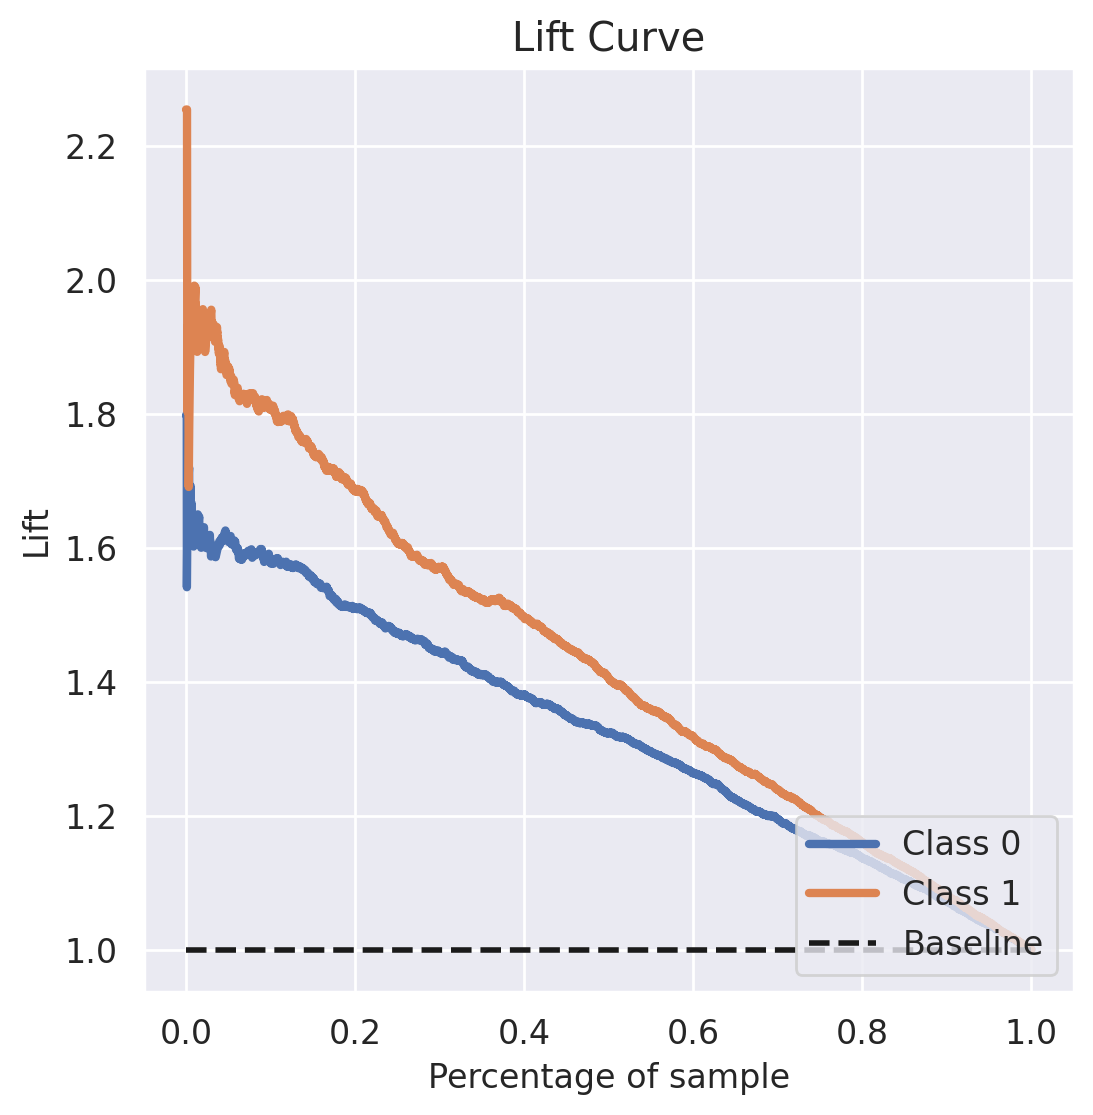

In [290]:
Accuracy, Precision, Recall, F1, auc_score, y_pred, y_prob = evaluationMetricsGCV(x_test, y_test, rf_model)
model_stats = model_stats.append({"Model": "Random Forest model",
                                    "Accuracy": Accuracy,
                                    "Precision": Precision,
                                    "Recall": Recall,
                                    "F1-Score": F1,
                                    "AUC-Score": auc_score}, ignore_index=True)

In [291]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0       Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244
1  Decision Tree model  0.673412   0.646717  0.581682  0.612478   0.664127
2            SVM model  0.664123   0.630522  0.586916  0.607938   0.656308
3  Random Forest model  0.687842   0.663102  0.602617  0.631414   0.679215

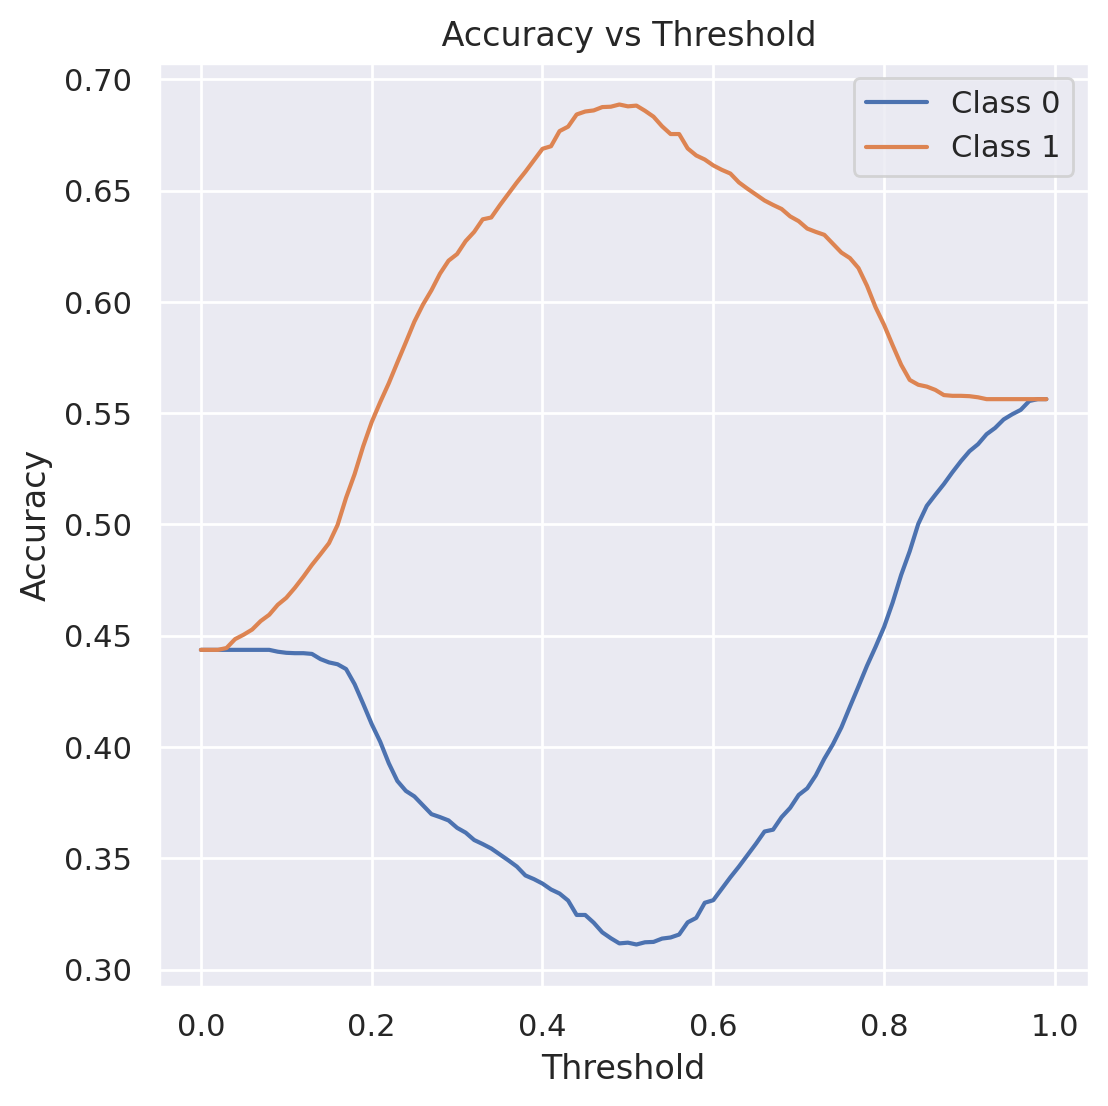

In [292]:
# Display how change the accuracy metric using differnt thresholds
x = []
acc_0 = []
acc_1 = []
for th in np.arange(0.0, 1.0, 0.01):
    y_pred_new_0 = y_prob[:,0] >= th
    y_pred_new_1 = y_prob[:,1] >= th
    acc_0.append(accuracy_score(y_test, y_pred_new_0))
    acc_1.append(accuracy_score(y_test, y_pred_new_1))
    x.append(th)
plt.plot(x, acc_0, label = "Class 0")
plt.plot(x, acc_1, label = "Class 1")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title(" Accuracy vs Threshold")
plt.legend()
plt.show()

### 3.5. K-Nearest Neighbor Model

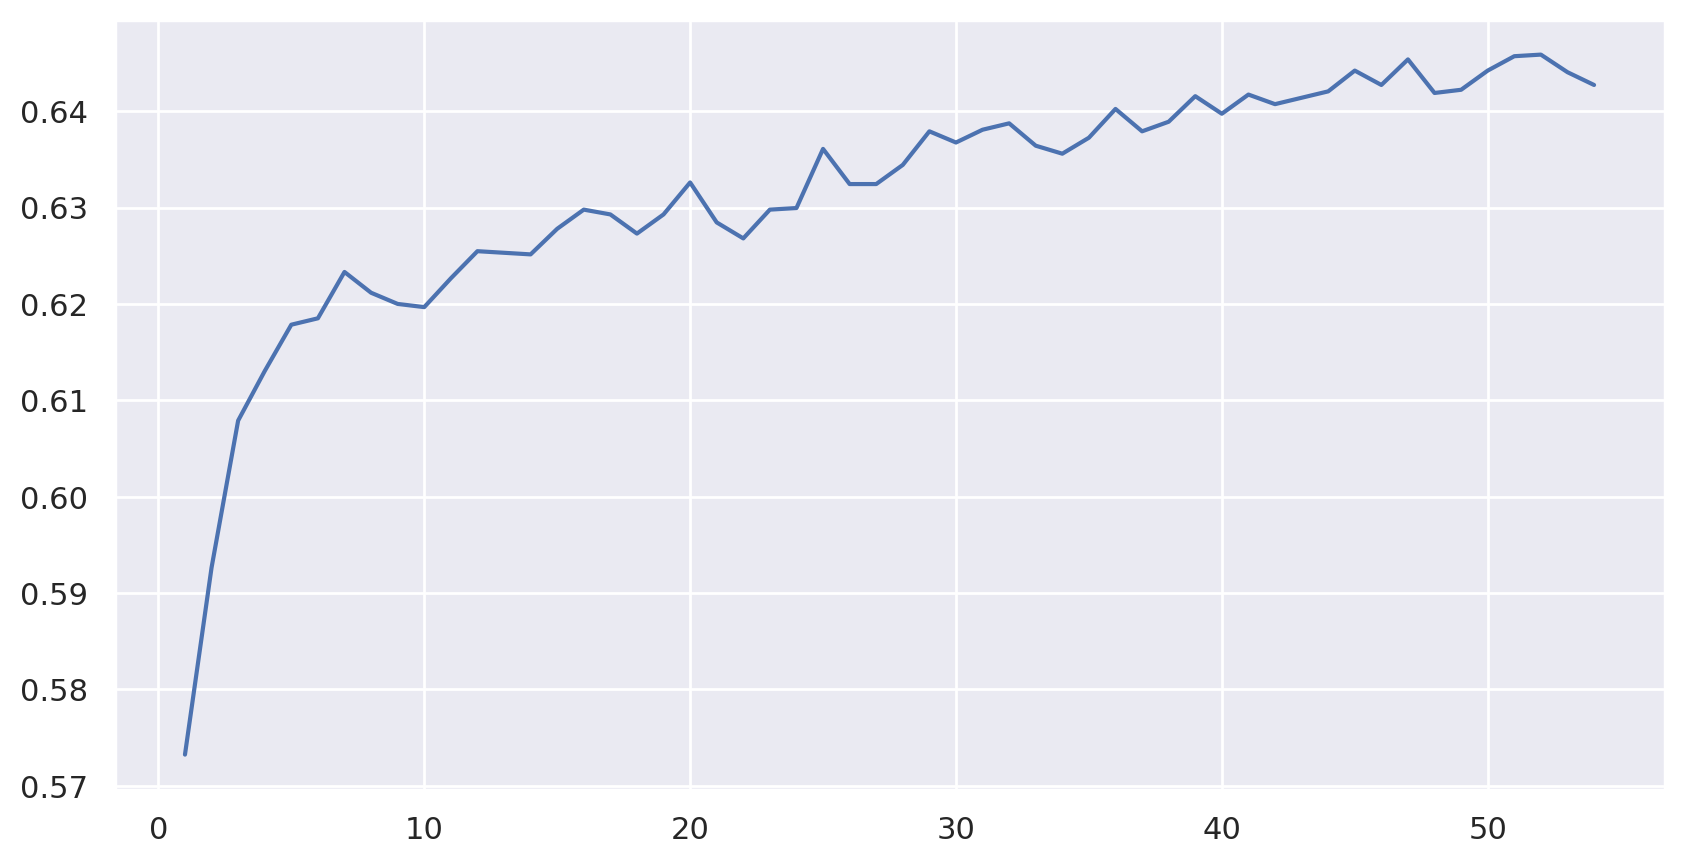

In [293]:
knn_scores = []
for i in range(1,55):
    knn = KNeighborsClassifier(n_neighbors  = i)
    knn.fit(x_train,y_train)
    knn_scores.append(knn.score(x_test,y_test))

plt.figure(figsize=(10,5))    
sns.lineplot(x = range(1,55), y = knn_scores)
plt.show()

In [294]:
for idx, value in enumerate(knn_scores) :
    print(idx ,':', value)

0 : 0.5732293912755018
1 : 0.5926355946259745
2 : 0.6078951733289103
3 : 0.613036987891856
4 : 0.6178470724829989
5 : 0.6185105324266047
6 : 0.6233206170177475
7 : 0.6211643722010284
8 : 0.620003317299718
9 : 0.619671587327915
10 : 0.6226571570741416
11 : 0.6254768618344667
12 : 0.6253109968485653
13 : 0.6251451318626637
14 : 0.6277989716370874
15 : 0.6297893514679052
16 : 0.6292917565102008
17 : 0.627301376679383
18 : 0.6292917565102008
19 : 0.6326090562282303
20 : 0.6284624315806934
21 : 0.6268037817216785
22 : 0.6297893514679052
23 : 0.6299552164538066
24 : 0.6360922209321612
25 : 0.6324431912423287
26 : 0.6324431912423287
27 : 0.6344335710731465
28 : 0.6379167357770774
29 : 0.6367556808757672
30 : 0.638082600762979
31 : 0.6387460607065848
32 : 0.6364239509039642
33 : 0.6355946259744568
34 : 0.6372532758334716
35 : 0.6402388455796981
36 : 0.6379167357770774
37 : 0.6389119256924863
38 : 0.6415657654669099
39 : 0.6397412506219937
40 : 0.6417316304528115
41 : 0.6407364405374025
42 : 0.

#### Hyperparameters Tunning

1. Finding "n_neighbors"

In [ ]:
# GridSearchCV for KNN

parameters = {}
parameters['n_neighbors'] = [i for i in range(1,50)]
#parameters['weights'] = ['uniform', 'distance']
#parameters['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

#
GS_knn_0 = GridSearchCV(KNeighborsClassifier(), parameters , scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_knn_0.fit(x_train, y_train)

In [296]:
GridSearchResults(GS_knn_0)

Best parameters: 
 {'n_neighbors': 37}
Best score: 
 0.63380 (+/-0.00678)
All parameters: 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 37,
 'p': 2,
 'weights': 'uniform'}


params  mean_test_score  std_test_score  rank_test_score
36  {'n_neighbors': 37}         0.633796        0.006776                1
37  {'n_neighbors': 38}         0.632374        0.009099                2
38  {'n_neighbors': 39}         0.631309        0.004983                3
35  {'n_neighbors': 36}         0.630597        0.007942                4
34  {'n_neighbors': 35}         0.630454        0.008985                5
32  {'n_neighbors': 33}         0.630241        0.008958                6
30  {'n_neighbors': 31}         0.629885        0.010527                7
22  {'n_neighbors': 23}         0.629033        0.010570                8
33  {'n_neighbors': 34}         0.629032        0.009545                9
31  {'n_neighbors': 32}         0.628677        0.009892               10

2. Finding 'weights' and 'algorithm'

In [ ]:
# GridSearchCV for KNN

parameters = {}
parameters['n_neighbors'] = [37]
parameters['weights'] = ['uniform', 'distance']
parameters['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

#
GS_knn_1 = GridSearchCV(KNeighborsClassifier(), parameters,  scoring = 'accuracy', cv = 10, verbose=1, n_jobs=-1)
GS_knn_1.fit(x_train, y_train)

In [299]:
GridSearchResults(GS_knn_1)

Best parameters: 
 {'algorithm': 'auto', 'n_neighbors': 37, 'weights': 'uniform'}
Best score: 
 0.63380 (+/-0.00678)
All parameters: 
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 37,
 'p': 2,
 'weights': 'uniform'}


params  mean_test_score  \
0  {'algorithm': 'auto', 'n_neighbors': 37, 'weig...         0.633796   
4  {'algorithm': 'kd_tree', 'n_neighbors': 37, 'w...         0.633796   
2  {'algorithm': 'ball_tree', 'n_neighbors': 37, ...         0.633156   
6  {'algorithm': 'brute', 'n_neighbors': 37, 'wei...         0.632871   
7  {'algorithm': 'brute', 'n_neighbors': 37, 'wei...         0.629176   
3  {'algorithm': 'ball_tree', 'n_neighbors': 37, ...         0.629175   
1  {'algorithm': 'auto', 'n_neighbors': 37, 'weig...         0.628820   
5  {'algorithm': 'kd_tree', 'n_neighbors': 37, 'w...         0.628820   

   std_test_score  rank_test_score  
0        0.006776                1  
4        0.006776                1  
2        0.007650                3  
6        0.008304                4  
7        0.008075                5  
3        0.008405                6  
1        0.008363                7  
5        0.008363                7

#### Modeling

In [311]:
knn_model = KNeighborsClassifier(algorithm='auto', n_neighbors = 37, weights = 'uniform')
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=37)

In [312]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 37,
 'p': 2,
 'weights': 'uniform'}

#### Evaluation



Results: 
+++++ Accuracy Score 0.638
+++++ Precision Score 0.606
+++++ Recall Score 0.524
+++++ F1 Score 0.562


              precision    recall  f1-score   support

    No churn       0.66      0.73      0.69      3354
       Churn       0.61      0.52      0.56      2675

    accuracy                           0.64      6029
   macro avg       0.63      0.63      0.63      6029
weighted avg       0.63      0.64      0.63      6029

+++++ AUC (Area under the ROC Curve) : 0.626





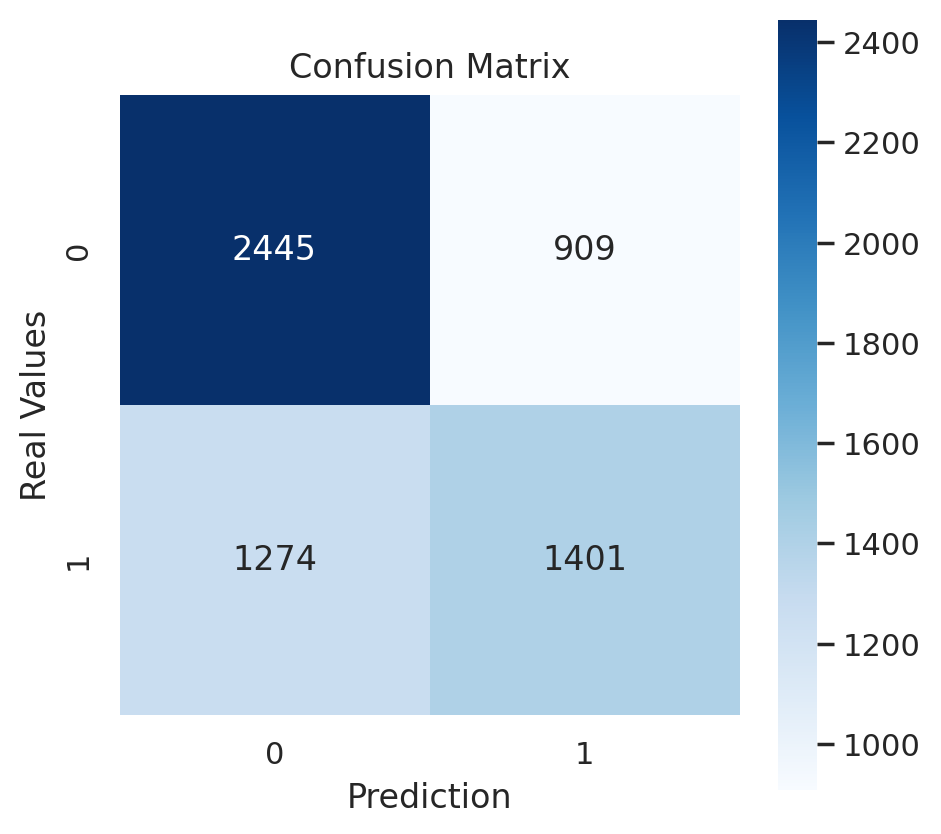

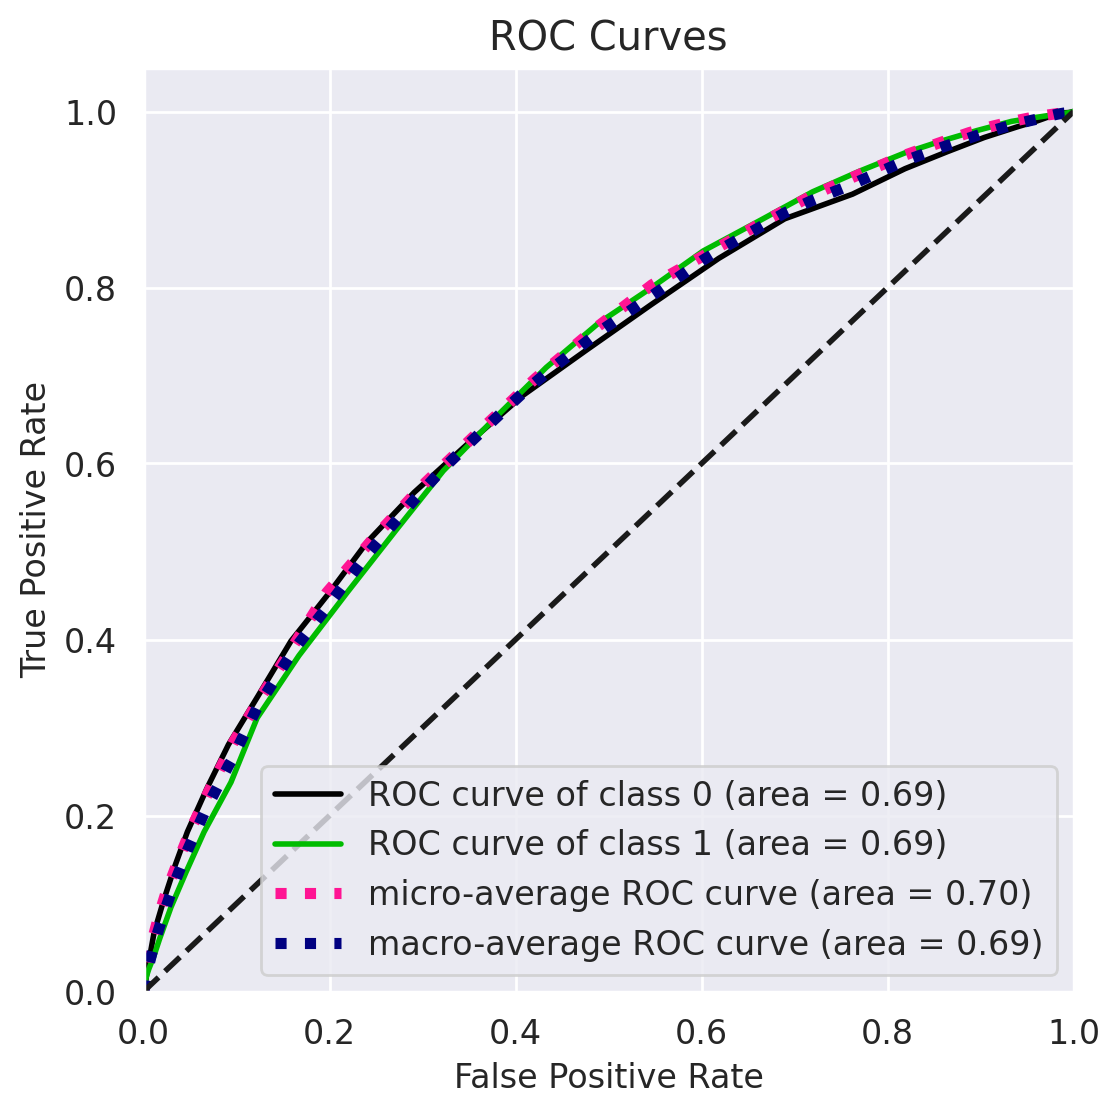

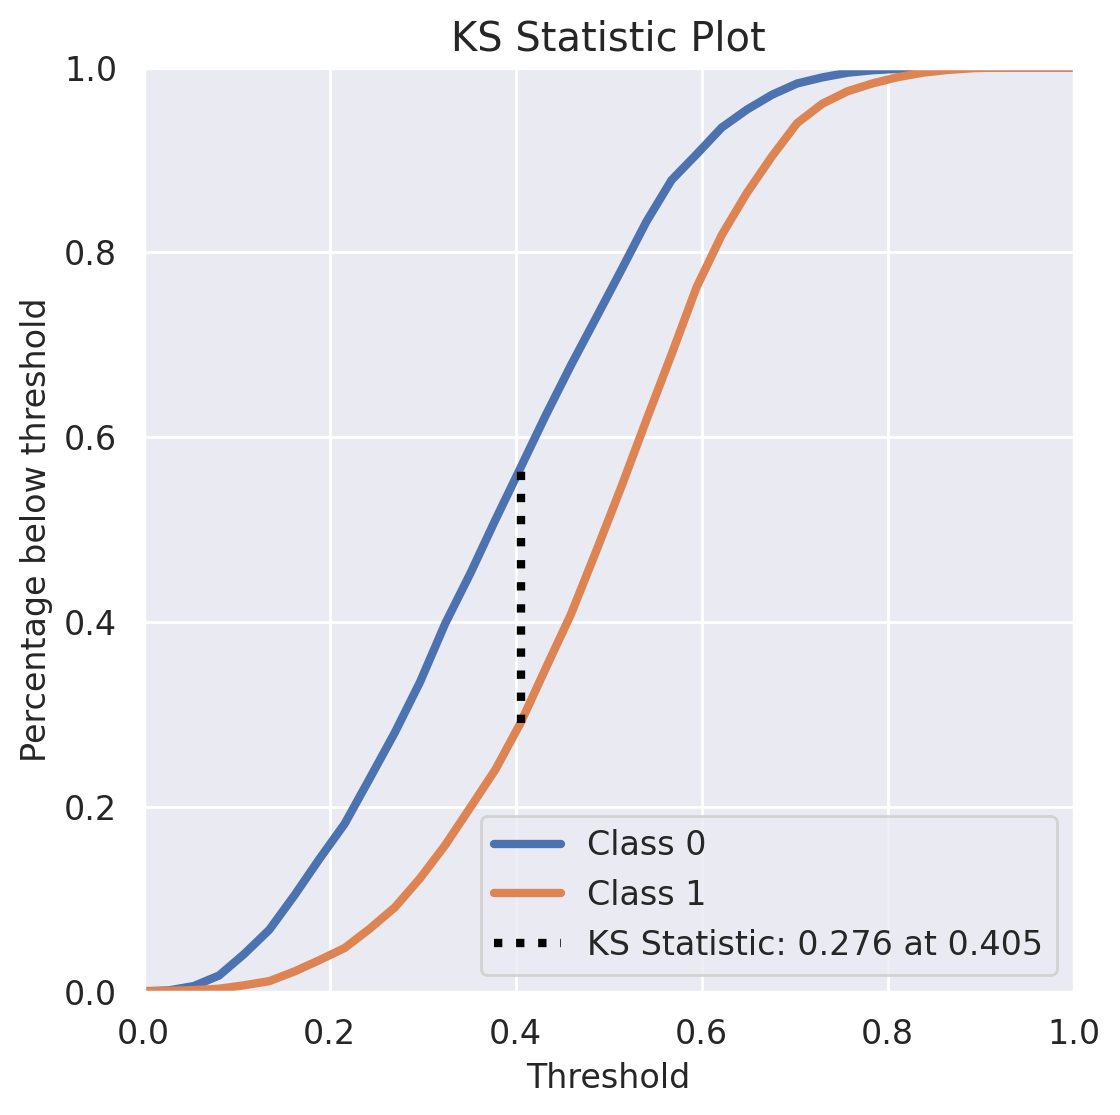

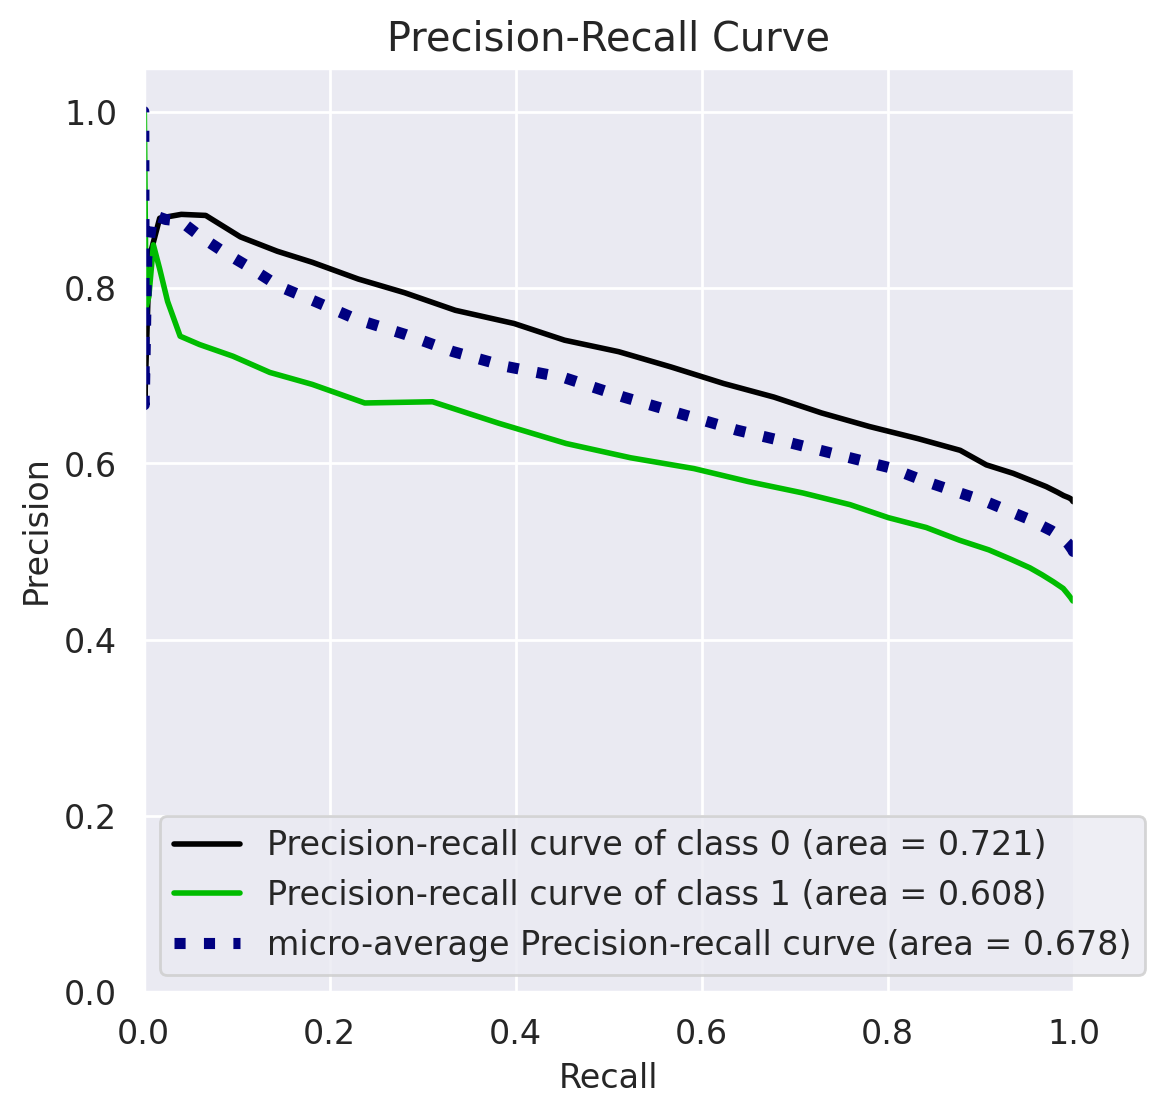

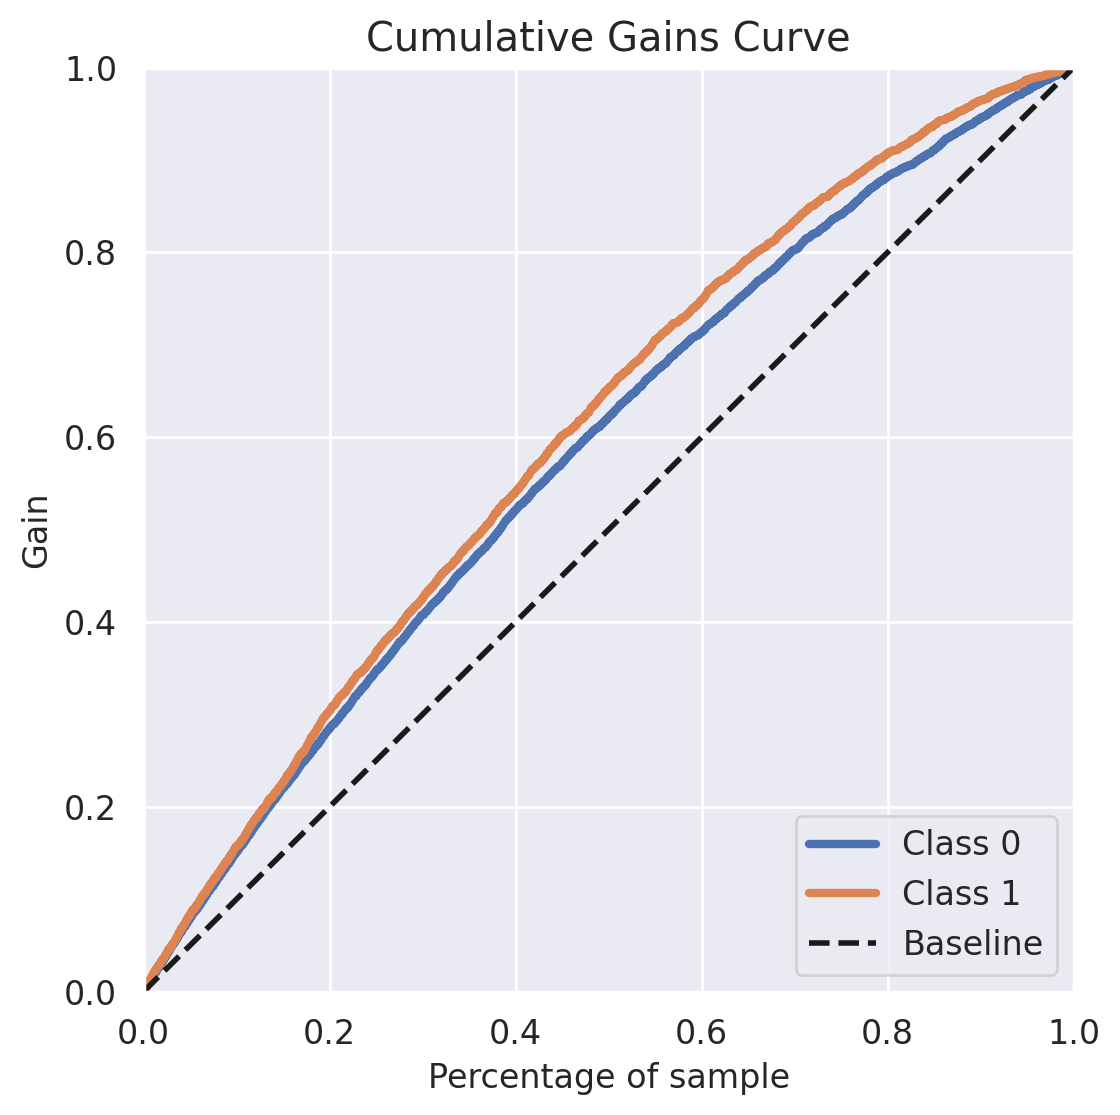

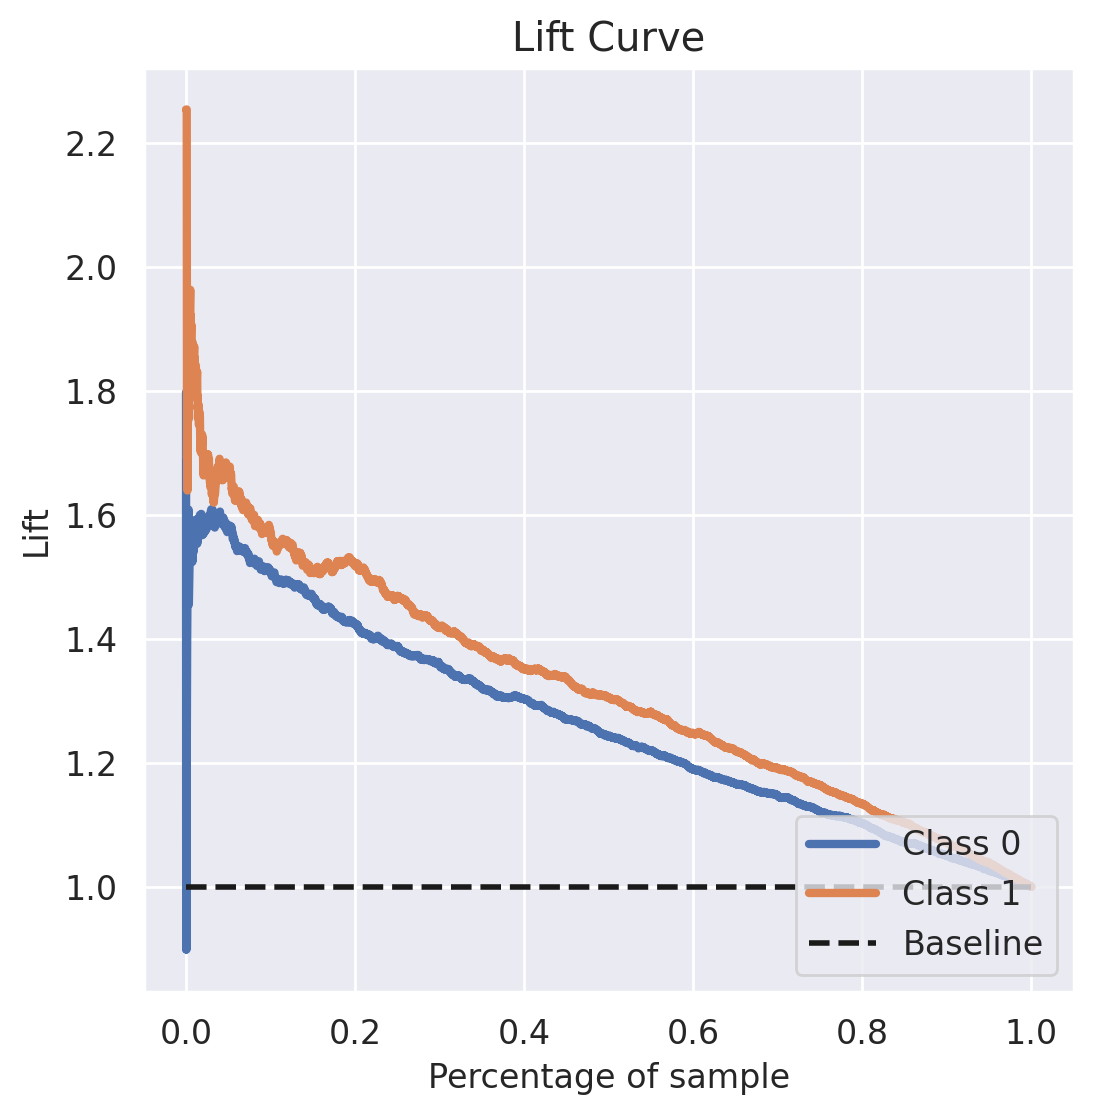

In [313]:
Accuracy, Precision, Recall, F1, auc_score, y_pred, y_prob = evaluationMetricsGCV(x_test, y_test, knn_model)
model_stats = model_stats.append({"Model": "KNN model",
                                    "Accuracy": Accuracy,
                                    "Precision": Precision,
                                    "Recall": Recall,
                                    "F1-Score": F1,
                                    "AUC-Score": auc_score}, ignore_index=True)

In [314]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0       Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244
1  Decision Tree model  0.673412   0.646717  0.581682  0.612478   0.664127
2            SVM model  0.664123   0.630522  0.586916  0.607938   0.656308
3  Random Forest model  0.687842   0.663102  0.602617  0.631414   0.679215
4            KNN model  0.637917   0.606494  0.523738  0.562086   0.626359

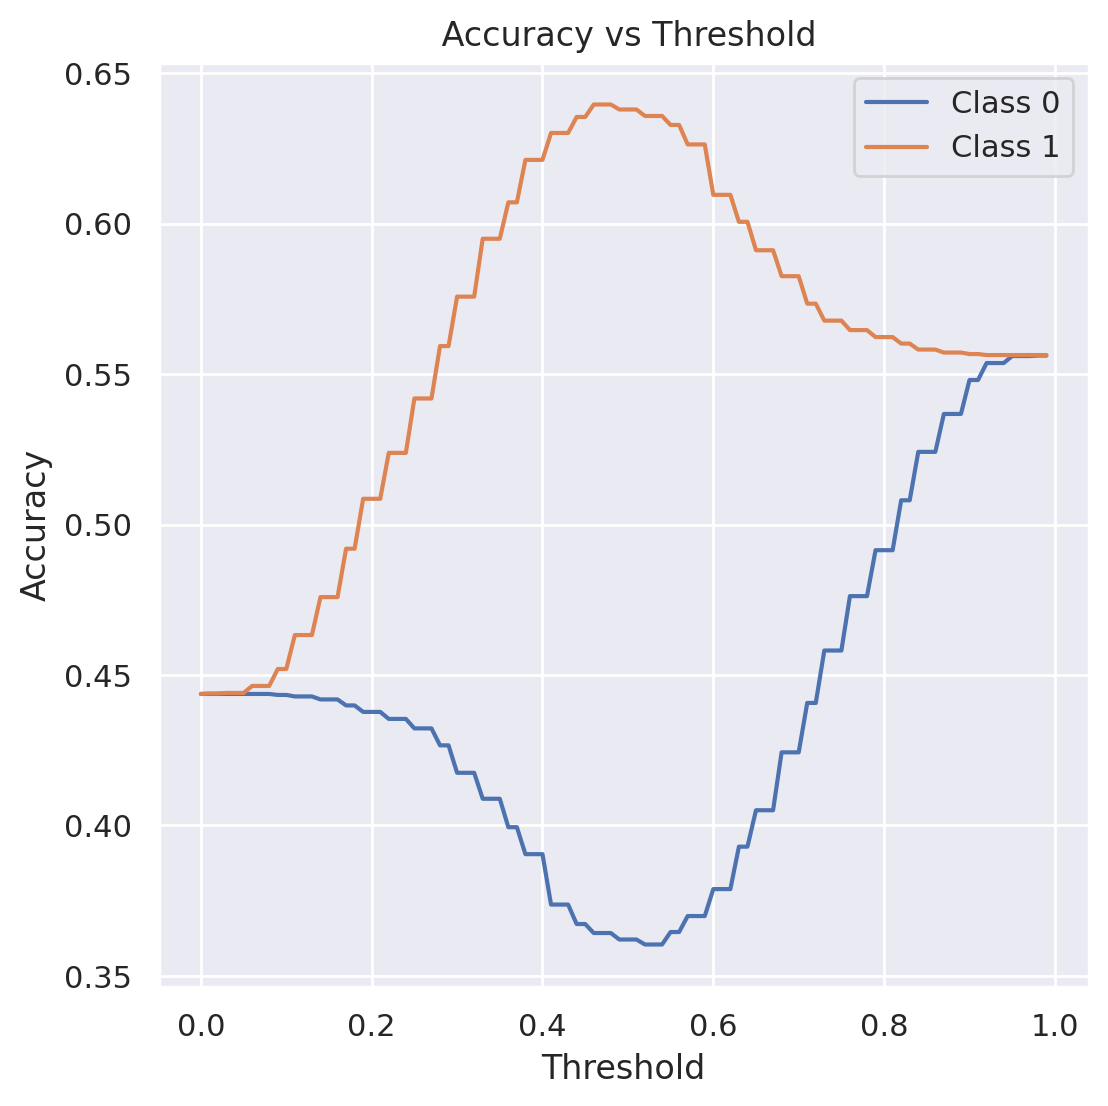

In [315]:
# Display how change the accuracy metric using differnt thresholds
x = []
acc_0 = []
acc_1 = []
for th in np.arange(0.0, 1.0, 0.01):
    y_pred_new_0 = y_prob[:,0] >= th
    y_pred_new_1 = y_prob[:,1] >= th
    acc_0.append(accuracy_score(y_test, y_pred_new_0))
    acc_1.append(accuracy_score(y_test, y_pred_new_1))
    x.append(th)
plt.plot(x, acc_0, label = "Class 0")
plt.plot(x, acc_1, label = "Class 1")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title(" Accuracy vs Threshold")
plt.legend()
plt.show()

### Summary

Now we have all the statistics and results of all models. As we can  see the best model is Random Forest whicha has a better accuracy(0.69) than others.

In [317]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0       Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244
1  Decision Tree model  0.673412   0.646717  0.581682  0.612478   0.664127
2            SVM model  0.664123   0.630522  0.586916  0.607938   0.656308
3  Random Forest model  0.687842   0.663102  0.602617  0.631414   0.679215
4            KNN model  0.637917   0.606494  0.523738  0.562086   0.626359

## 4. Save the model

In [321]:
model_stats.head()

Model  Accuracy  Precision    Recall  F1-Score  AUC-Score
0       Logistic model  0.639244   0.598039  0.570093  0.583732   0.632244
1  Decision Tree model  0.673412   0.646717  0.581682  0.612478   0.664127
2            SVM model  0.664123   0.630522  0.586916  0.607938   0.656308
3  Random Forest model  0.687842   0.663102  0.602617  0.631414   0.679215
4            KNN model  0.637917   0.606494  0.523738  0.562086   0.626359

In [318]:
model_stats.to_markdown()

'|    | Model               |   Accuracy |   Precision |   Recall |   F1-Score |   AUC-Score |\n|---:|:--------------------|-----------:|------------:|---------:|-----------:|------------:|\n|  0 | Logistic model      |   0.639244 |    0.598039 | 0.570093 |   0.583732 |    0.632244 |\n|  1 | Decision Tree model |   0.673412 |    0.646717 | 0.581682 |   0.612478 |    0.664127 |\n|  2 | SVM model           |   0.664123 |    0.630522 | 0.586916 |   0.607938 |    0.656308 |\n|  3 | Random Forest model |   0.687842 |    0.663102 | 0.602617 |   0.631414 |    0.679215 |\n|  4 | KNN model           |   0.637917 |    0.606494 | 0.523738 |   0.562086 |    0.626359 |\n|  5 | KNN model           |   0.637917 |    0.606771 | 0.522617 |   0.561559 |    0.626246 |\n|  6 | KNN model           |   0.637751 |    0.6066   | 0.522243 |   0.56127  |    0.626059 |\n|  7 | KNN model           |   0.637917 |    0.606494 | 0.523738 |   0.562086 |    0.626359 |'

We saved the model with pickle option in order to use later in prediction test. 

In [ ]:
!pwd

/home/yon/Documents/Personal_Plan/Project_3_ChurnRatePrediction/projectChurnRate


In [322]:
# Saving the model:
filename = 'modelChurn.pickle'
pickle.dump(rf_model, open(filename,'wb'))